# Change Point Detection: Australian General Practitioner Visits During Covid-19

### Thomas Bowe
19/02/2021

In this notebook I attempt to detect significant changes in the mean frequency of General Practitioner (GP) visits by Australians over time with emphasis on assessing the impact of the Covid-19 Pandemic.

This is intended as a personal exercise in developing my skills in using R by:
* Experimenting with change point detection functions, 
* using loops to detect changes across multiple categories quickly and easily, 
* resolving change points visually with ggplot, and
* creating effective small multiples to display multiple change points

I will use publicly available MBS data to quantify the widely reported negative effect that the pandemic has had on the frequency of people seeing their GP in person for things such as: 

* Chronic disease management, 
* Mental health treatment plans,
* Women's health (including cervical screening), and 
* Aboriginal and Torres Strait Islander people's health assessments.

Importantly, there was a series of temporary MBS telehealth items added in mid March to help reduce the risk of community transmission in GP surgeries. The frequency of these over-the-phone interactions was included in our analysis.

What I hope will be the outcome of this analysis is a revelation into the precise magnitude of the Covid-19 pandemic's effect on GP visits, and therefore the overall health of the Australian People. It will serve as a resource to improve the post Covid-19 Health of Australia by objectively highlighting particular health conditions that may be being impacted more than others.

It is hypothesised that all in person visits will have been negatively impacted to some extent, while overall interactions where telehealth was available would have increased, particularly around mental health treatment plans.

For the detection of change points in the time series data I will be using the changepoint package in R to apply the binary segmentation method:

>*"Binary segmentation (BS) is a generic technique for multiple change-point detection in which, initially, the entire dataset is searched for one changepoint, typically via a CUSUM-like procedure. If and once a change-point is detected, the data are then split into two (hence the name ‘binary’) subsegments, defined by the detected change-point. A similar search is then performed on either subsegment, possibly resulting in further splits." - Piotr Fryzlewicz 2014*

#### My method of investigation will progress as follows:
1. Explore the data on hand and gauge the overall frequency of each category of health check-up.

2. Explore the overall trend in GP visits from 1 July 2010 to December 2020 to see if any patterns emerge.

3. What effect did the temporary telehealth MBS items have on GP interactions in Australia?

4. I note a distinct drop in in-person visits after the Covid-19 pandemic began in Australia but an increase in overall interactions, so I zoom into the data and apply binary segmentation change point detection to the period from 1 January 2018 to December 2020, the detected change points align with the onset of Covid-19.

5. Common types of GP visits are now faceted to assess if any items are affected more than others, or if some are totally unaffected. I observe some obvious items which are heavily affected so I apply change point detection to assess if it aligns with the pandemic. I note that despite the presence of a temporary telehealth MBS item, Aboriginal and Torres Strait Islander Health Assessments still decreased.

7. Finally, I explore cervical screening in more detail and see if I can reliably identify a second change point being 1 May 2017 where the recommended frequency of cervical screens was reduced significantly.

The data used in this notebook is sourced from: http://medicarestatistics.humanservices.gov.au/statistics/mbs_item.jsp.

In [1]:
# Install packages
install.packages("changepoint")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# Load packages
library(tidyverse)
library(kableExtra)
library(scales)
library(IRdisplay)
library(lubridate)
library(changepoint)
library(extrafontdb)
library(extrafont)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Successfully loaded changepoint package version 2.2.2
 NOTE: Prede

In [3]:
# Create the figure height function for use in each plot
fig_height <- function(heigth) {
  options(repr.plot.width = 14, repr.plot.height = heigth)
}

# Create the core theme function
theme_tb <- function() {
  theme(
    panel.background = element_blank(),
    axis.ticks = element_blank(),    
    plot.title = element_text(size = 26, hjust = 0),                                  
    plot.background = element_rect(fill = "#FBF7EE", colour = "#FBF7EE"),                                       
    plot.subtitle = element_text(hjust = 0, size = 14),          
    plot.caption = element_text(size = 14, hjust = 1),                           
    axis.title = element_text(size = 18),             
    axis.text.y = element_text(size = 18),          
    axis.text.x = element_text(size = 18, margin = margin(5, b = 10)),
    strip.text = element_text(size = 16, hjust = 0, face = "bold"),
    strip.background = element_blank(),
    plot.margin = unit(c(1,2,.5,.5), "cm")
  )
}

# Create the horizontal grid theme function
theme_tb_vert <- function() {
  theme( 
    panel.grid.major.x = element_line(colour = "grey", size = 0.2),
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank()
  )
}

# Create the vertical grid theme function
theme_tb_hori <- function() {
  theme( 
    panel.grid.major.y = element_line(colour = "grey", size = 0.2),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank()
  )
}

# Create the blank grid theme function
theme_tb_blan <- function() {
  theme( 
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )
}

# Define the caption for each chart
capt <-
  "Source: Medicare Statistics\n2021 | Data Visualisation by Tom Bowe"

# Define the number of change points to try and detect
cpt_num <- 1

# Define the date at which to begin the change point detection
cpt_date <- as.Date("2017-12-31")

# Define a range of time that defines the start of covid
cov_start1 <- as.Date("2020-01-25")
cov_start2 <- as.Date("2020-03-13")

# Define colour palette
col_ln <- "#EF3F28"
col_pt <- "#8D9195"

# Import data and quickly change the date field to a date format
mbs_lookup <-
  read.csv(
    '../input/common-gp-mbs-items-australia/mbs_item_lookup.csv'
  )

mbs <-
  read.csv(
    '../input/common-gp-mbs-items-australia/common_gp_mbs_items_jul10_to_dec20_unpivoted.csv'
  ) %>%
  mutate(Date = as.Date(Date)) %>%
  mutate(Year = year(Date)) %>%
  inner_join(mbs_lookup) %>%
  mutate(

# Replace this long string with something that won't run off the page
    Name = str_replace_all(
      Name,
      "Aboriginal & Torres Strait Islander People's Health Assessment",
      "Aboriginal & TSI"
    )
  ) %>%
  select(Item, Name, State, Date, Count, Temporary_Covid) %>%
  subset(!(Name %in% c("Asthma Cycle of Care","Diabetes Cycle of Care","Practice Nurses")))

# Create a subset without the temp covid mbs items
mbs_precovid <- subset(mbs, Temporary_Covid == 'N')

ggplotchangepoint <-
  function(data, changes = 2) {
    library(changepoint)
    library(ggplot2)
    mcpt <- cpt.mean(data$x, method = 'BinSeg', Q = changes)
    mcpt.pts <- attributes(mcpt)$cpts
    mcpt.mean <- attributes(mcpt)$param.est$mean
    data$mean <- rep(mcpt.mean, c(mcpt.pts[1], diff(mcpt.pts)))
    ggplot(data)
  }

Joining, by = "Item"



## Preview the Data
The data I am working with is sourced from the www.http://medicarestatistics.humanservices.gov.au/ website. I have selected common GP Medicare Benefit Schedule (MBS) item numbers which represent what most Australians are visiting their GP for.

The data presents like the following:

In [4]:
# Present data preview
head(mbs,20)

,Item,Name,State,Date,Count,Temporary_Covid
,<int>,<chr>,<fct>,<date>,<int>,<fct>
3025,23,Standard GP Attendance,NSW,2010-07-01,2525990,N
3026,23,Standard GP Attendance,VIC,2010-07-01,1835546,N
3027,23,Standard GP Attendance,QLD,2010-07-01,1360221,N
3028,23,Standard GP Attendance,SA,2010-07-01,537296,N
3029,23,Standard GP Attendance,WA,2010-07-01,622946,N
3030,23,Standard GP Attendance,TAS,2010-07-01,162030,N
3031,23,Standard GP Attendance,ACT,2010-07-01,91350,N
3032,23,Standard GP Attendance,NT,2010-07-01,37159,N
3033,23,Standard GP Attendance,NSW,2010-08-01,2607307,N


I'm going to be assessing which MBS item categories were most affected by the pandemic. I will gauge quickly the overall frequency of each in these simple bar plots. 

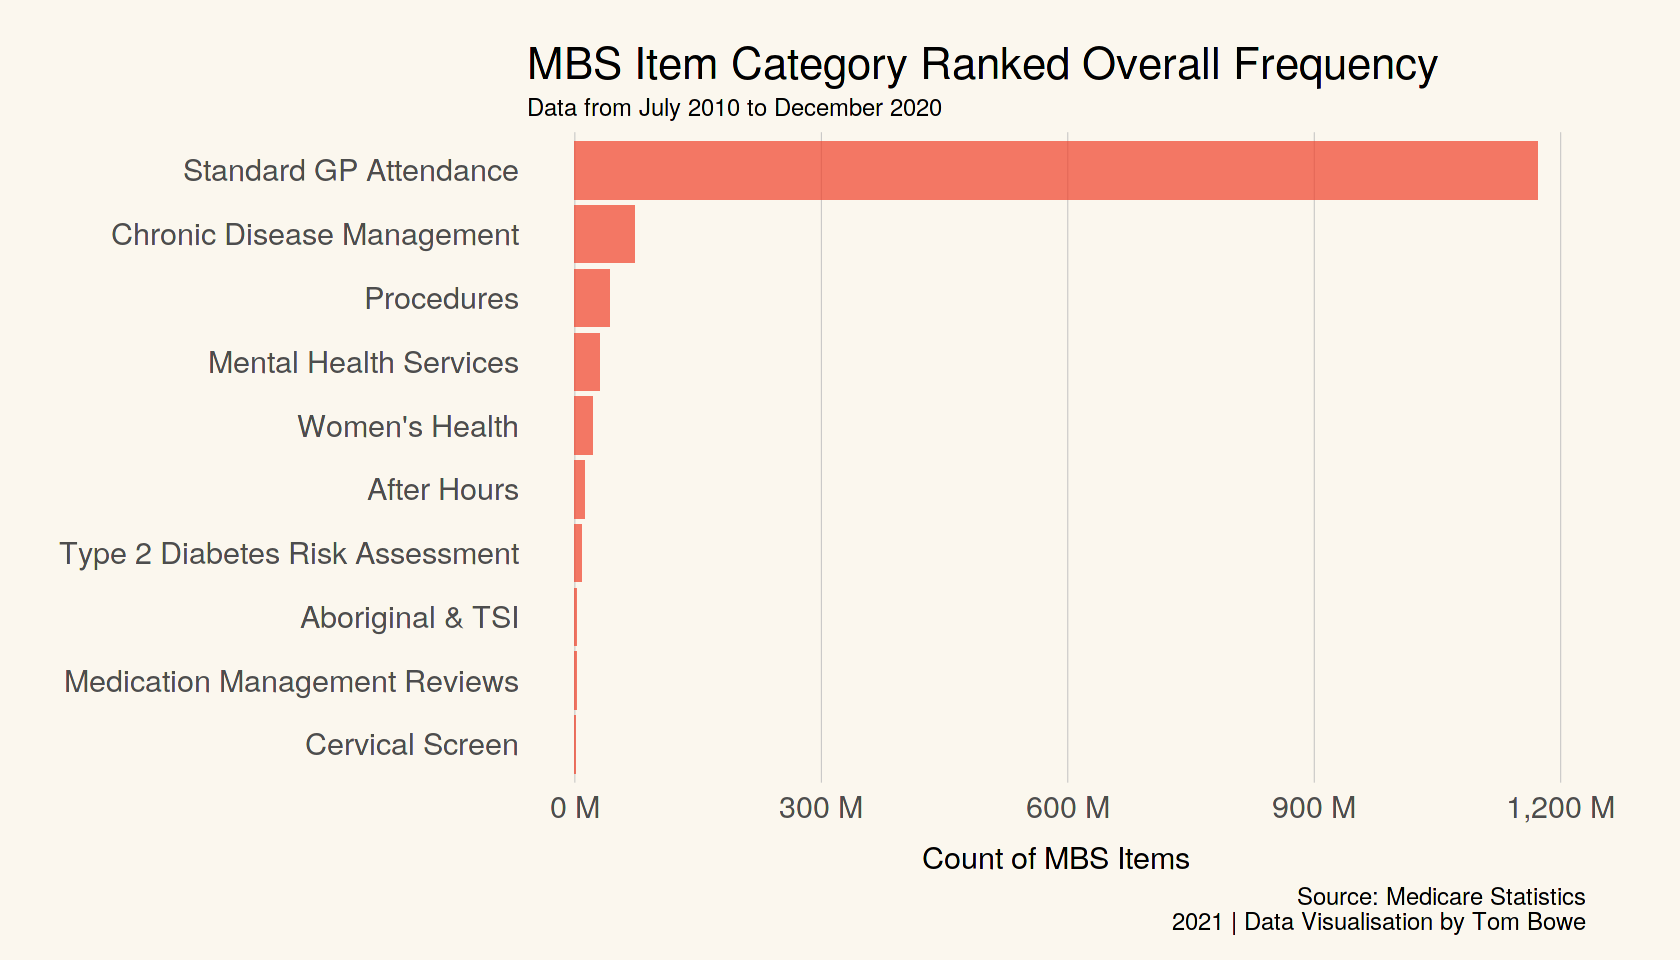

In [5]:
# Arrange the data
overall_freq <-
    aggregate(mbs$Count, by=list(Name=mbs$Name), FUN=sum)

# Visualise:
fig_height(8)
plt_overall_freq <- ggplot(overall_freq, aes(x = reorder(Name, x), y = x)) +
  scale_y_continuous(labels = unit_format(unit = "M", scale = 1e-6, accuracy = 1, big.mark = ",")) +
  geom_bar(stat = "identity",
           fill = col_ln,
           alpha = .7,
           width = .9) +
  theme_tb() +
  theme_tb_vert() +
  coord_flip() +
  labs(y = "Count of MBS Items", 
       x = "",
       title = "MBS Item Category Ranked Overall Frequency",
       subtitle = "Data from July 2010 to December 2020",
       caption = capt)
plt_overall_freq

## Trend in Check-ups from 2010 to 2020 at a Glance
I now plot every month's total number of check-ups over time and calculate the moving average. I have also drawn the approximate start of the Covid-19 pandemic in Australia being from the 25th of January when the first person tested positive, to the 15th of May when lockdowns started to take effect.

I immediately note a sharp downward trend following from the onset of the pandemic.

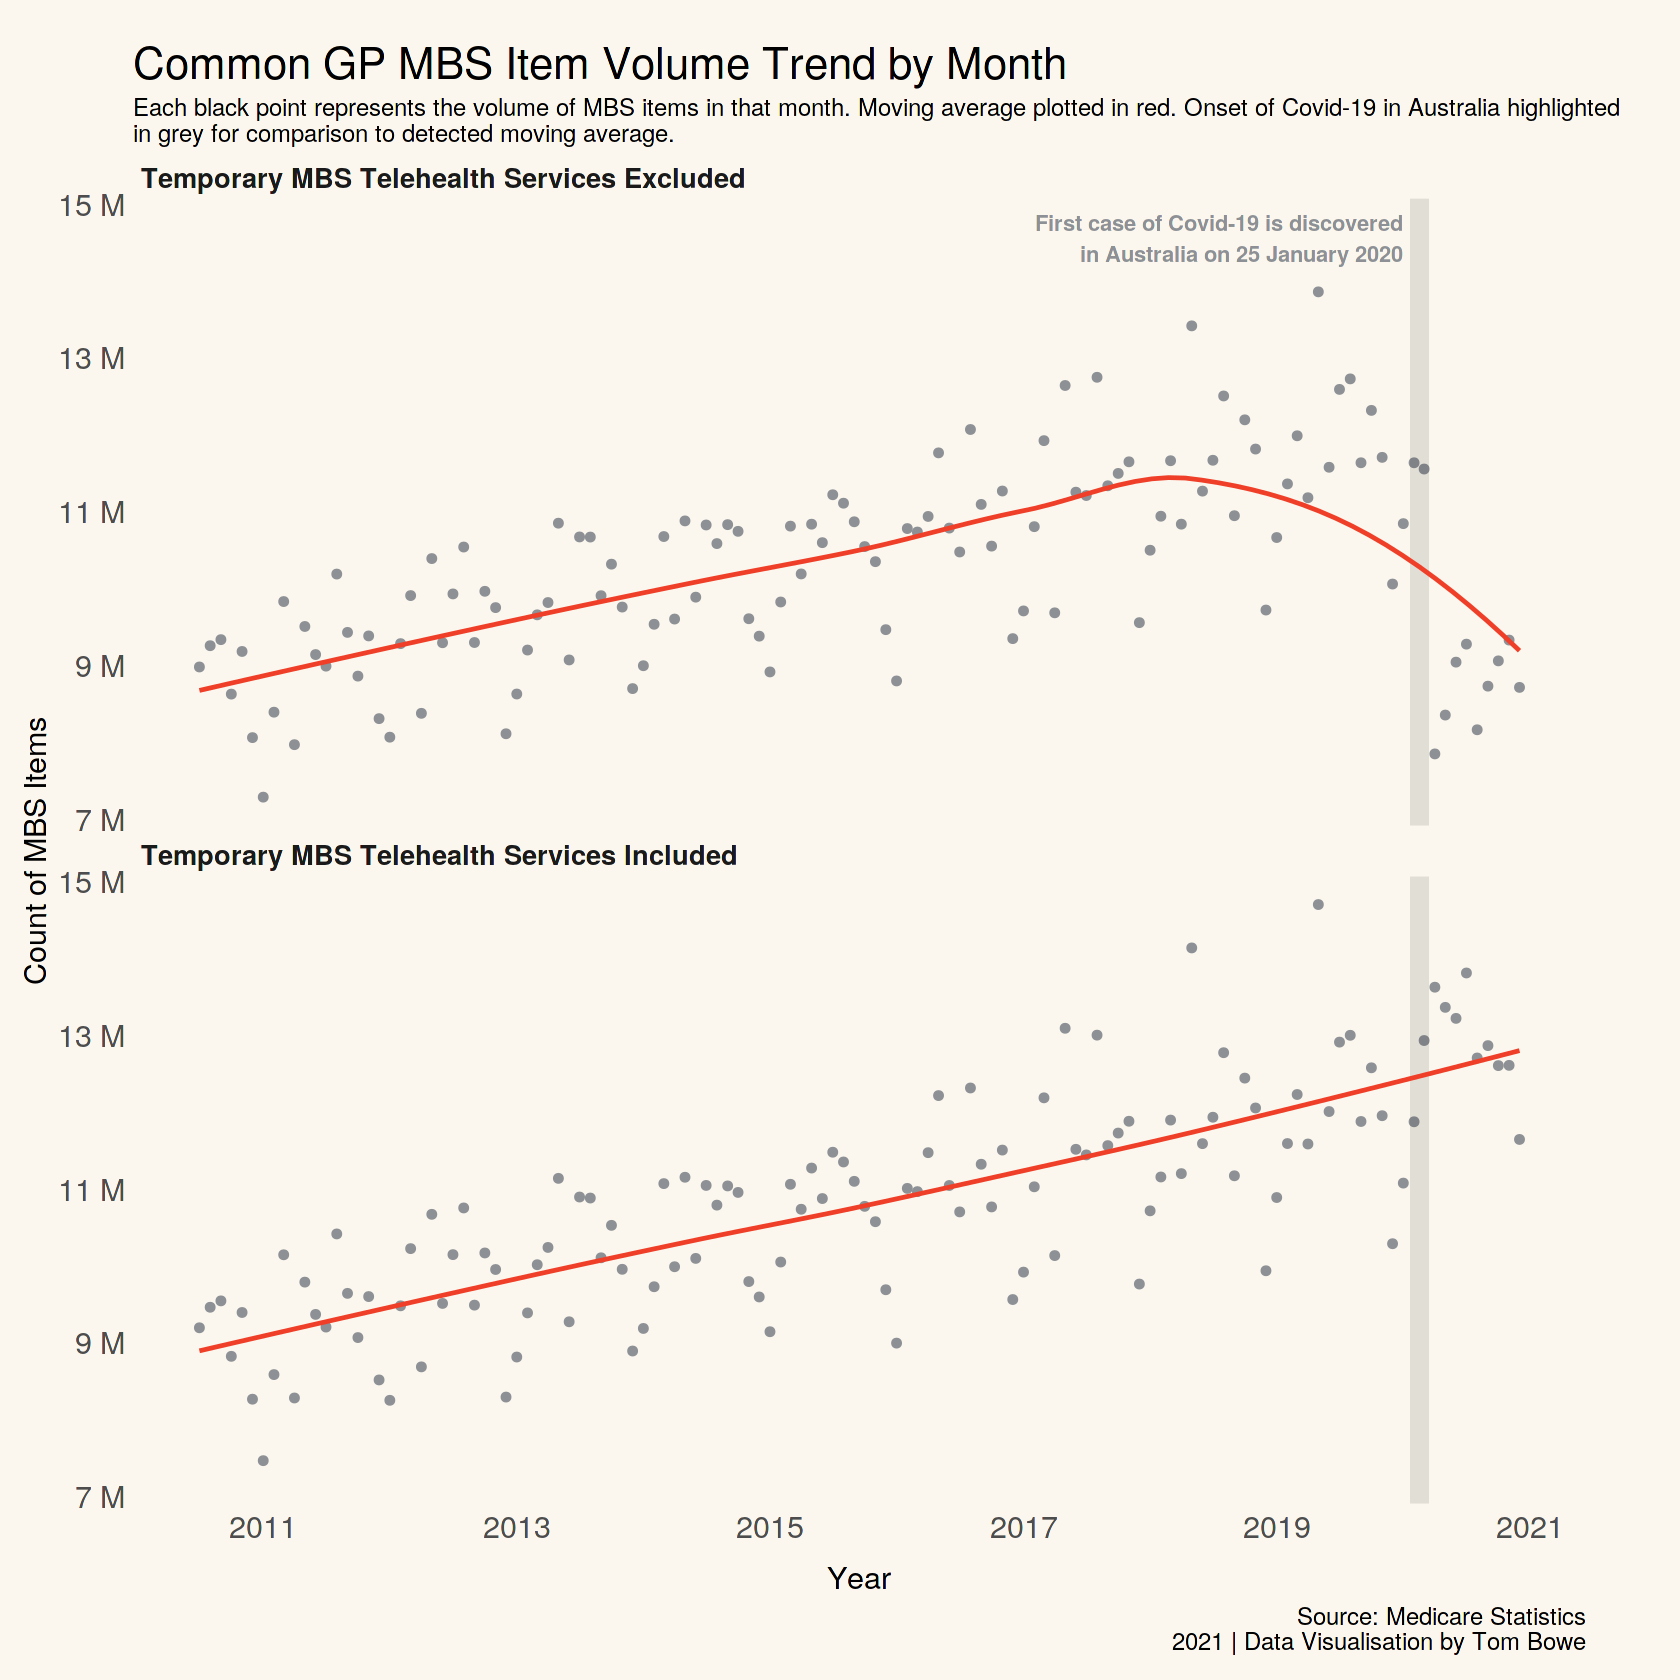

In [6]:
# Arrange the data
overall_trend_postcovid <-
    aggregate(mbs$Count, by=list(Date=mbs$Date), FUN=sum) %>%
    mutate(pre_post = "Temporary MBS Telehealth Services Included")
overall_trend_precovid <-
    aggregate(mbs_precovid$Count, by=list(Date=mbs_precovid$Date), FUN=sum) %>%
    mutate(pre_post = "Temporary MBS Telehealth Services Excluded")
overall_trend <- rbind(overall_trend_postcovid, overall_trend_precovid)
maxp <- max(overall_trend$x)

ann_text <- data.frame(Date = as.Date("2020-01-01"),x = maxp*0.99,lab = "Text",
                       pre_post = factor("Temporary MBS Telehealth Services Excluded",
                                         levels = c("Temporary MBS Telehealth Services Excluded",
                                                    "Temporary MBS Telehealth Services Included")))

# Visualise:
fig_height(14)
  ggplot(overall_trend, aes(x = Date, y = x)) +
  geom_point(size=2, colour = col_pt) +
  geom_vline(aes(xintercept = as.Date("2020-02-18")), size = 4, alpha = .1) + 
  geom_smooth(se=FALSE, colour = col_ln, lwd = 1, span = .5, formula = y ~ x, method = loess) +
  geom_text(data = ann_text, adj = 1, size = 4.5, fontface = "bold", colour = col_pt, 
            label = "First case of Covid-19 is discovered\nin Australia on 25 January 2020") +
  scale_y_continuous(labels = unit_format(unit = "M", scale = 1e-6, accuracy = 1)) +
  scale_x_date(date_breaks = "2 year", date_labels = "%Y") +
  theme_tb() +
  theme_tb_blan() +
  facet_wrap(~ pre_post, ncol = 1) +
  labs(y = "Count of MBS Items", 
       x = "Year",
       title = "Common GP MBS Item Volume Trend by Month",
       subtitle = "Each black point represents the volume of MBS items in that month. Moving average plotted in red. Onset of Covid-19 in Australia highlighted 
in grey for comparison to detected moving average.",
       caption = capt)

If I zoom in, from 2018 to 2020, then apply binary segmentation change point detection to the time series data, what do we see? 

A clear drop in average check-up frequency which coincides almost perfectly with the onset of the pandemic in Australia:

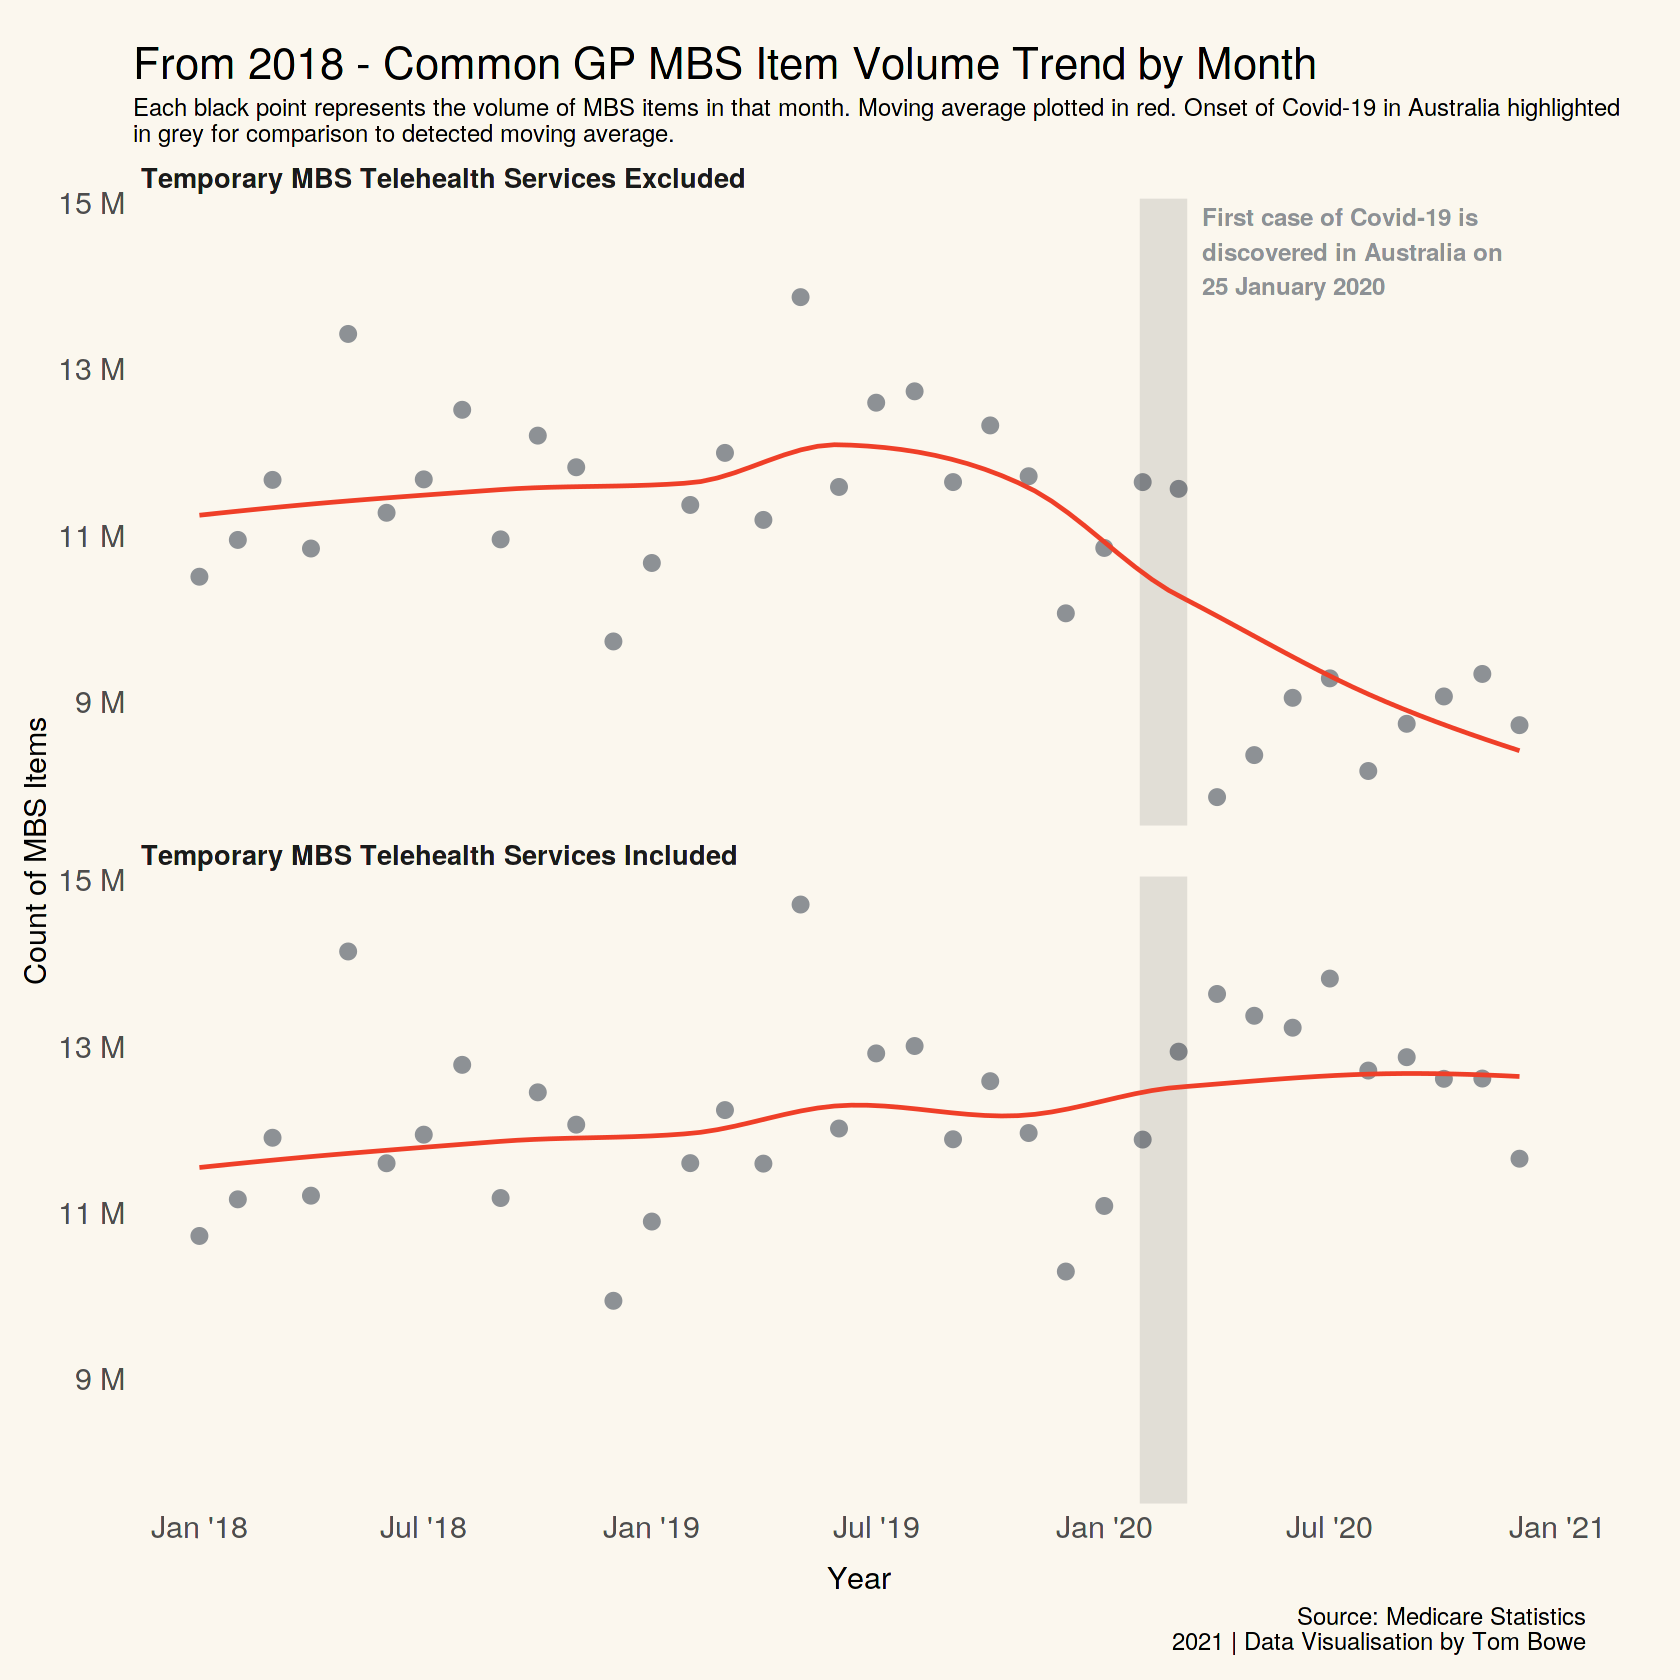

In [7]:
# Arrange the data
overall_trend_short <-
    subset(overall_trend, Date > cpt_date)

maxp <- max(overall_trend_short$x)

ann_text <- data.frame(Date = as.Date("2020-03-20"),x = maxp*0.98,lab = "Text",
                       pre_post = factor("Temporary MBS Telehealth Services Excluded",
                                         levels = c("Temporary MBS Telehealth Services Excluded",
                                                    "Temporary MBS Telehealth Services Included")))

# Visualise:
fig_height(14)
  ggplot(overall_trend_short, aes(x = Date, y = x)) +
  geom_point(size = 4, colour = col_pt) +
  geom_vline(aes(xintercept = as.Date("2020-02-18")), size = 10, alpha = .1) + 
  geom_smooth(se=FALSE, colour = col_ln, lwd = 1, span = .5, formula = y ~ x, method = loess) +
  geom_text(data = ann_text, adj = 0, size = 5, fontface = "bold", colour = col_pt, 
            label = "First case of Covid-19 is\ndiscovered in Australia on\n25 January 2020") +
  scale_y_continuous(labels = unit_format(unit = "M", scale = 1e-6, accuracy = 1)) +
  scale_x_date(breaks = breaks_pretty(n = 8), date_labels = "%b '%y") +
  theme_tb() +
  theme_tb_blan() +
  facet_wrap(~ pre_post, ncol = 1) +
  labs(y = "Count of MBS Items", 
       x = "Year",
       title = "From 2018 - Common GP MBS Item Volume Trend by Month",
       subtitle = "Each black point represents the volume of MBS items in that month. Moving average plotted in red. Onset of Covid-19 in Australia highlighted 
in grey for comparison to detected moving average.",
       caption = capt)

In [8]:
datalist <- 
    list()

for (i in c(
  "Temporary MBS Telehealth Services Included",
  "Temporary MBS Telehealth Services Excluded"
))
{
  dat <-
    subset(overall_trend_short, pre_post == i)
  mcpt_lp <-
    cpt.mean(dat$x, method = 'BinSeg', Q = cpt_num)
  mcpt_lp.pts <-
    attributes(mcpt_lp)$cpts
  mcpt_lp.mean <-
    attributes(mcpt_lp)$param.est$mean
  dat$mean <-
    rep(mcpt_lp.mean, c(mcpt_lp.pts[1], diff(mcpt_lp.pts)))
  dat$drop <-
    as.double((mcpt_lp.mean[2] - mcpt_lp.mean[1]) / mcpt_lp.mean[1])
  dat$i <-
    i
  datalist[[i]] <-
    dat
}

cpt_overall <-
  do.call(rbind, datalist)

Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”
Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”


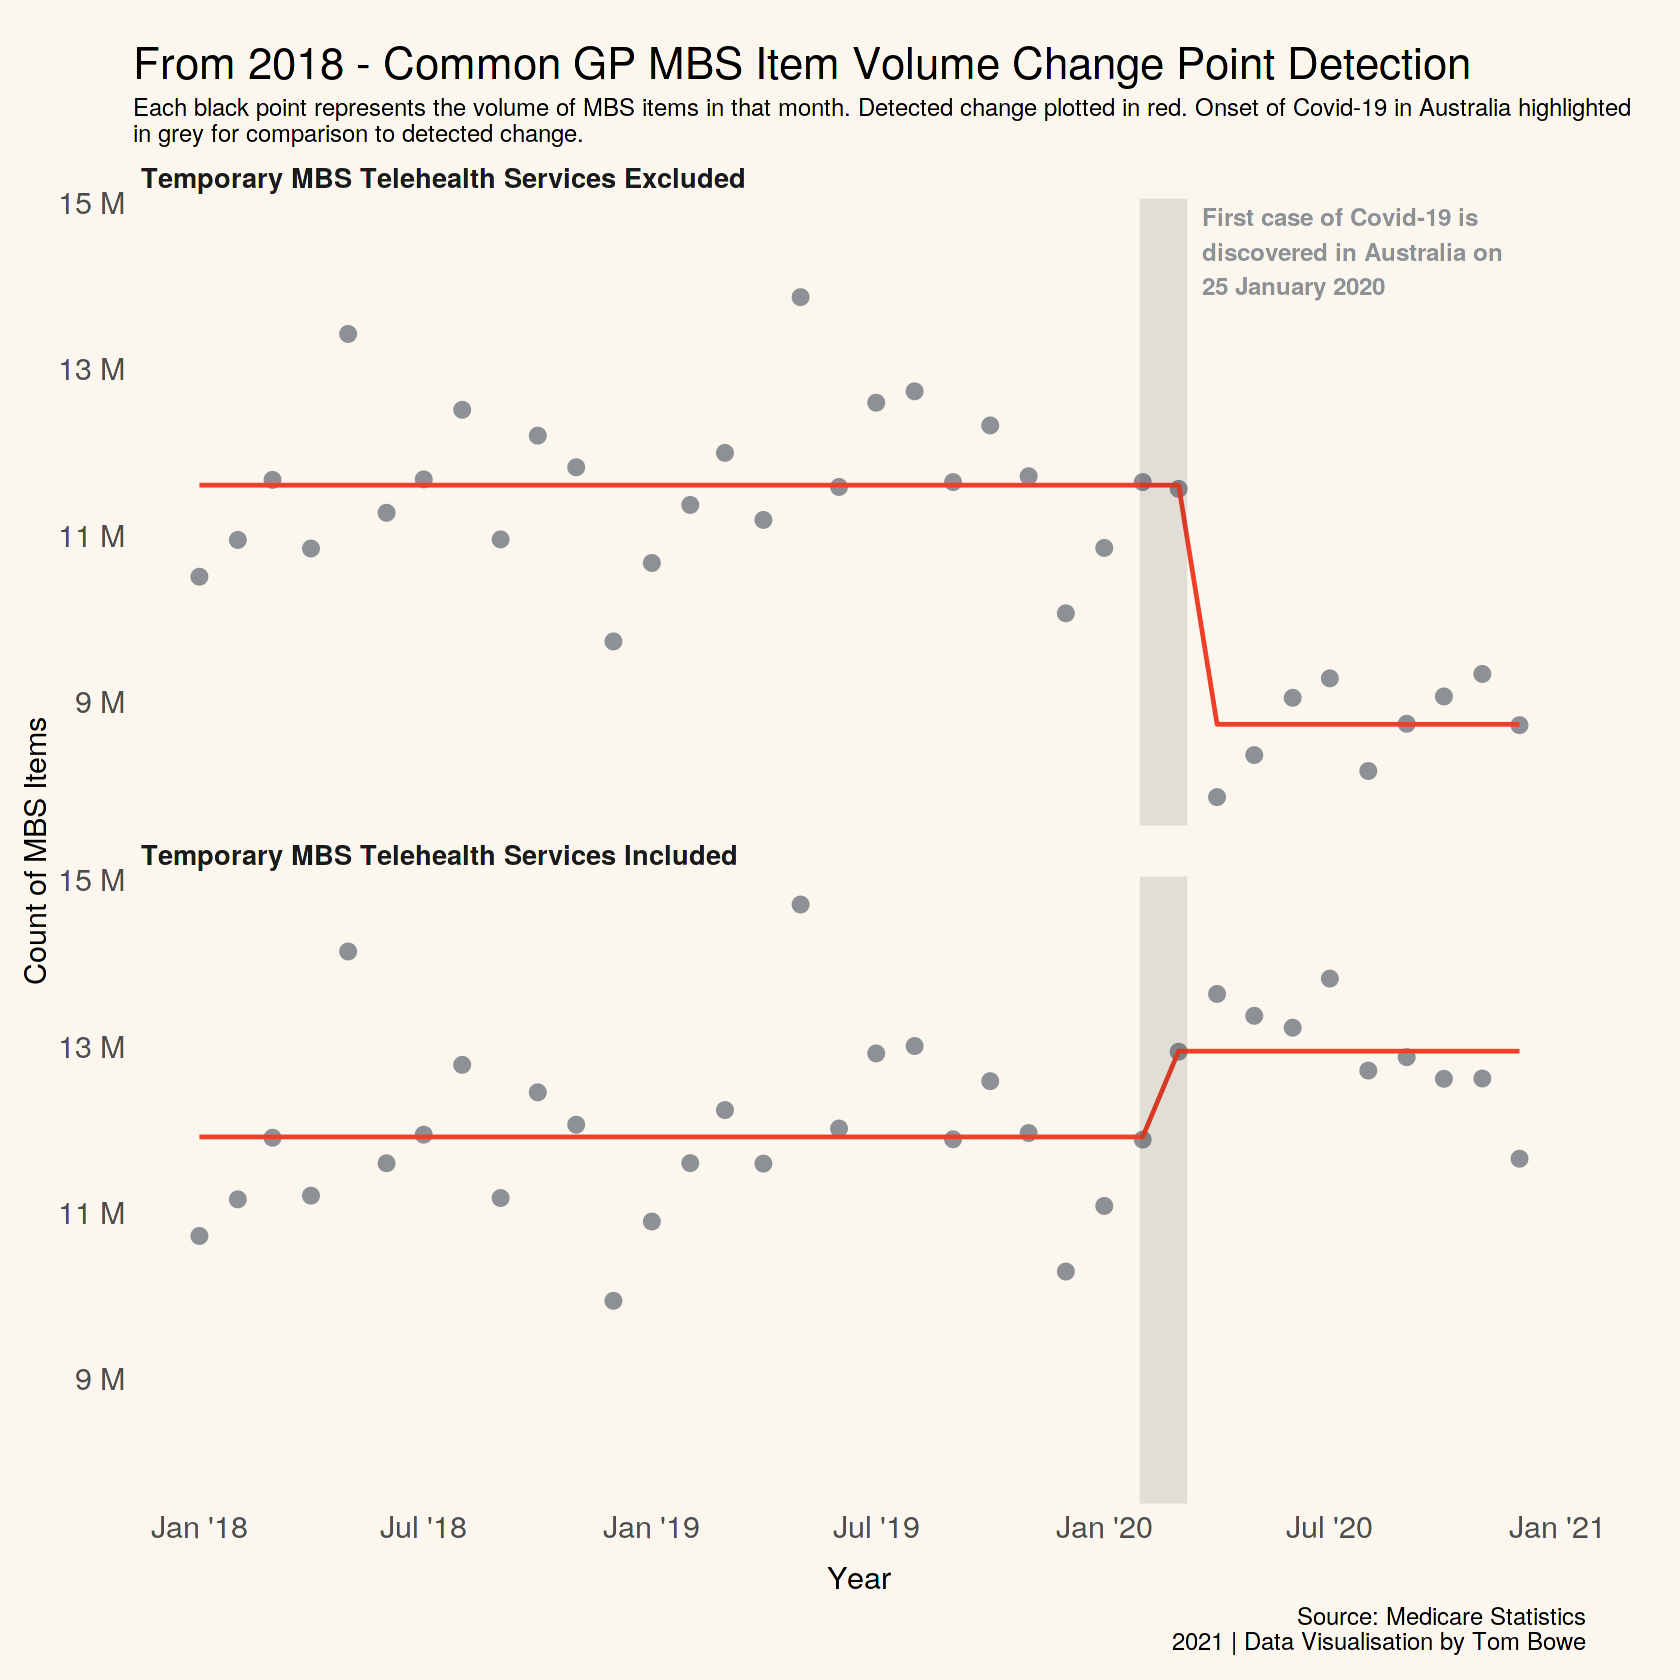

In [9]:
# Visualise:
fig_height(14)
  ggplot(cpt_overall, aes(x = Date, y = x)) +
  geom_point(size = 4, colour = col_pt) +
  geom_line(aes(Date, mean),colour = col_ln, lwd = 1) +
  geom_vline(aes(xintercept = as.Date("2020-02-18")), size = 10, alpha = .1) + 
  geom_text(data = ann_text, adj = 0, size = 5, fontface = "bold", colour = col_pt, 
            label = "First case of Covid-19 is\ndiscovered in Australia on\n25 January 2020") +
  scale_y_continuous(labels = unit_format(unit = "M", scale = 1e-6, accuracy = 1)) +
  scale_x_date(breaks = breaks_pretty(n = 8), date_labels = "%b '%y") +
  theme_tb() +
  theme_tb_blan() +
  facet_wrap(~ pre_post, ncol = 1) +
  labs(y = "Count of MBS Items", 
       x = "Year",
       title = "From 2018 - Common GP MBS Item Volume Change Point Detection",
       subtitle = "Each black point represents the volume of MBS items in that month. Detected change plotted in red. Onset of Covid-19 in Australia highlighted 
in grey for comparison to detected change.",
       caption = capt)

## Drilling Down into Each Main Category of Check-up Type
The MBS data I have sourced gives us information on what each item relates to and I can categorise these into main types. I have faceted our time series trend data by each of these types and discerned that some items have been obviously affected by the pandemic, while others seem to have remained unaffected.

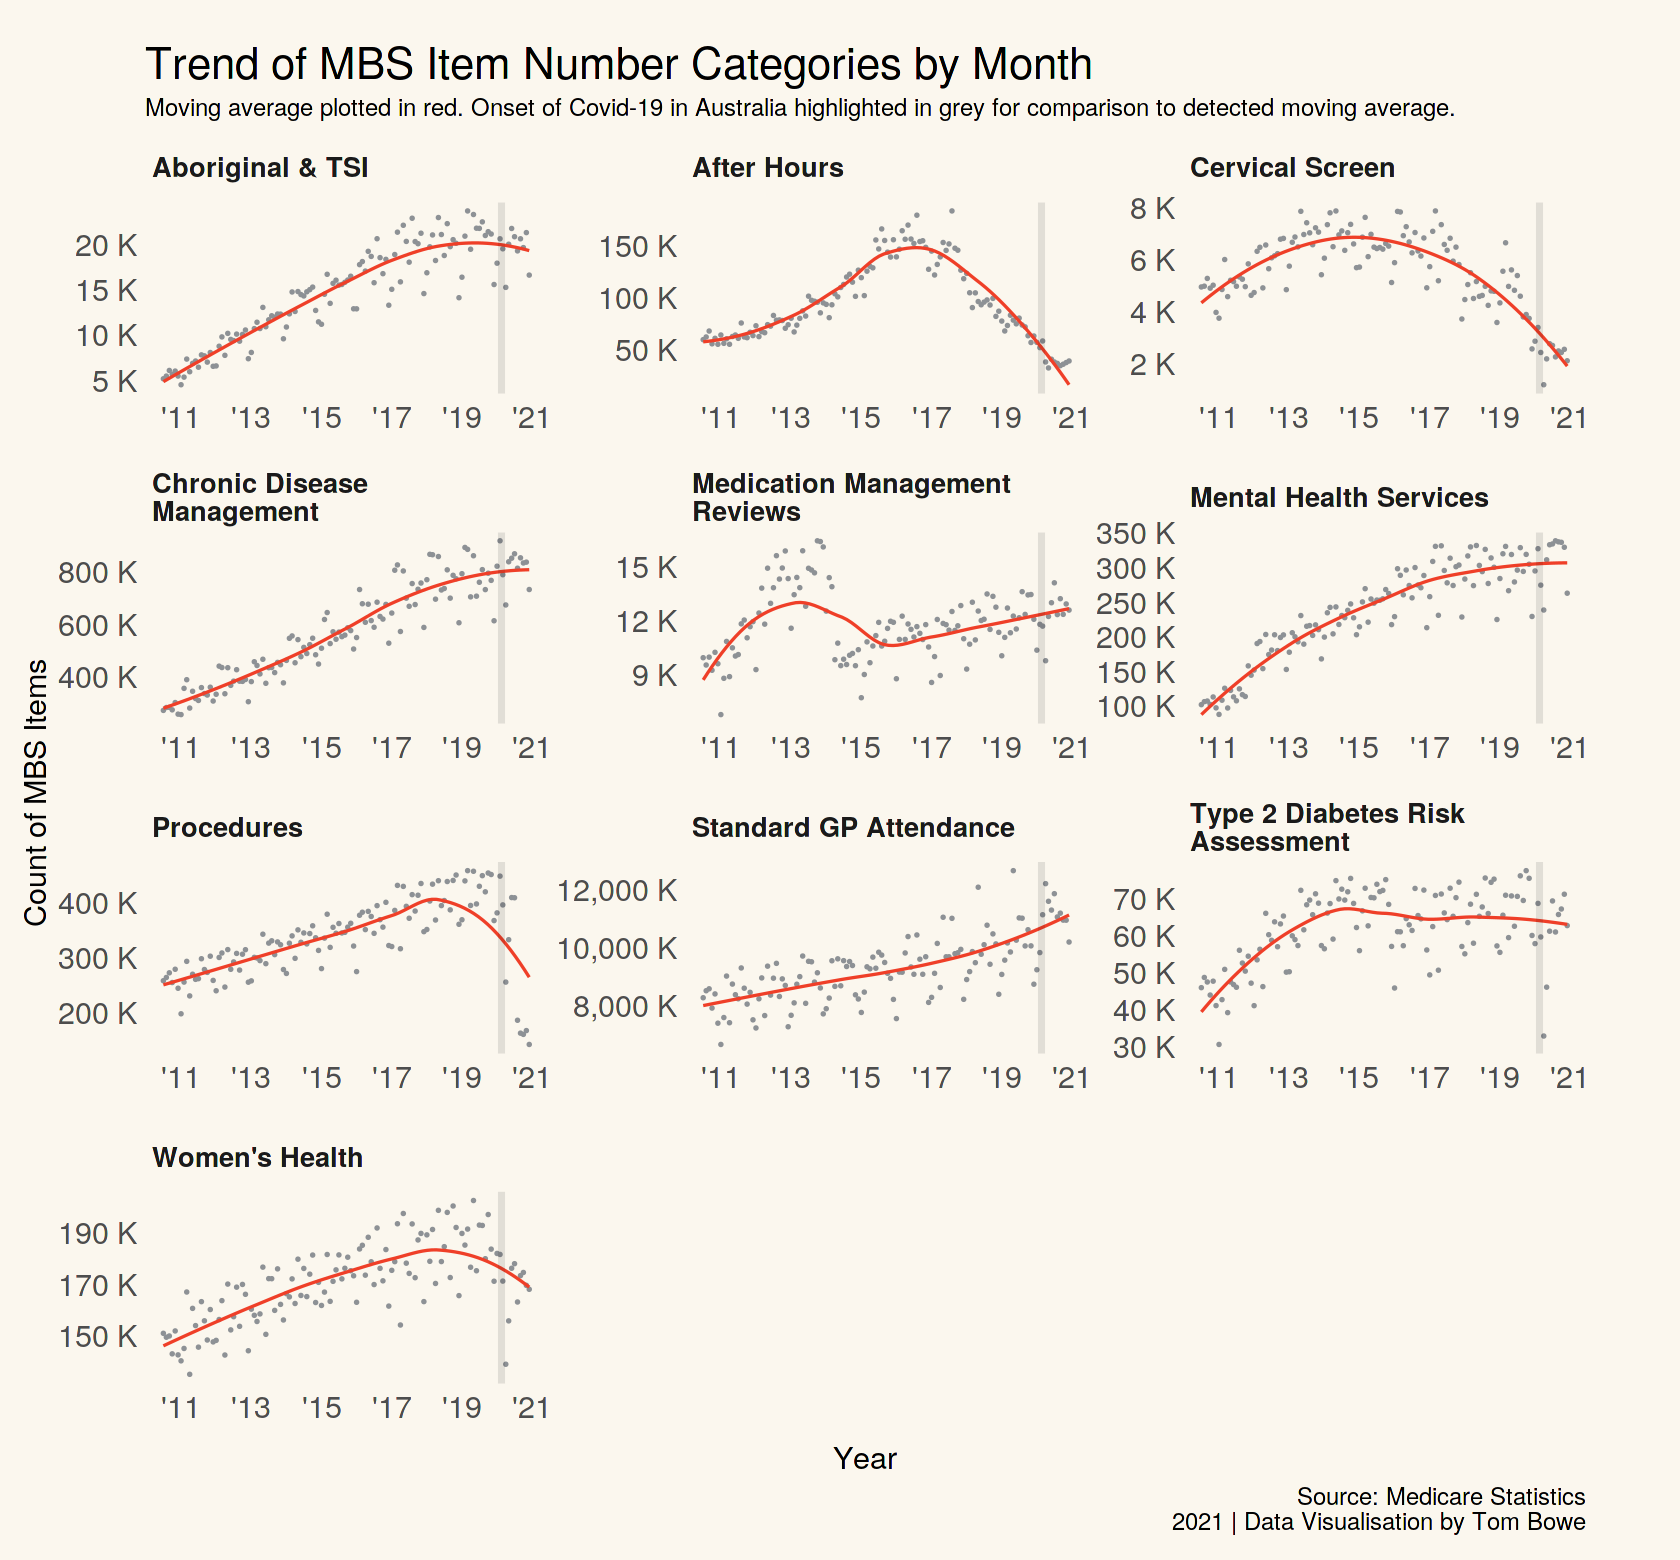

In [10]:
# Arrange the data
facet_trend_inc <-
    aggregate(mbs$Count, by=list(Date=mbs$Date, Name=mbs$Name), FUN=sum)

facet_trend_exc <-
    aggregate(mbs_precovid$Count, by=list(Date=mbs_precovid$Date, Name=mbs_precovid$Name), FUN=sum)

# Visualise:
fig_height(13)
ggplot(facet_trend_inc, aes(x = Date, y = x)) +
geom_point(size=.5, colour = col_pt) +
geom_smooth(se=FALSE, colour = col_ln, lwd = .7, span = .5, formula = y ~ x, method = loess) +
geom_vline(aes(xintercept = as.Date("2020-02-18")), size = 1.5, alpha = .1) +
facet_wrap(~ Name, scales = "free", ncol = 3, labeller = label_wrap_gen()) +
scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-3, accuracy = 1, big.mark = ",")) +
scale_x_date(date_breaks = "2 years", date_labels = "'%y") +
theme_tb() +
theme_tb_blan() +
labs(y = "Count of MBS Items", 
     x = "Year",
     title = "Trend of MBS Item Number Categories by Month",
     subtitle = "Moving average plotted in red. Onset of Covid-19 in Australia highlighted in grey for comparison to detected moving average.",
     caption = capt)

I have subsetted the data for the obviously affected check-up types and present them below with data from 2018 onwards, throughout the pandemic period.

Now let's take a look at the data if I apply changepoint detection. I can tell vaguely some types are more affected than other but let's firm this up:

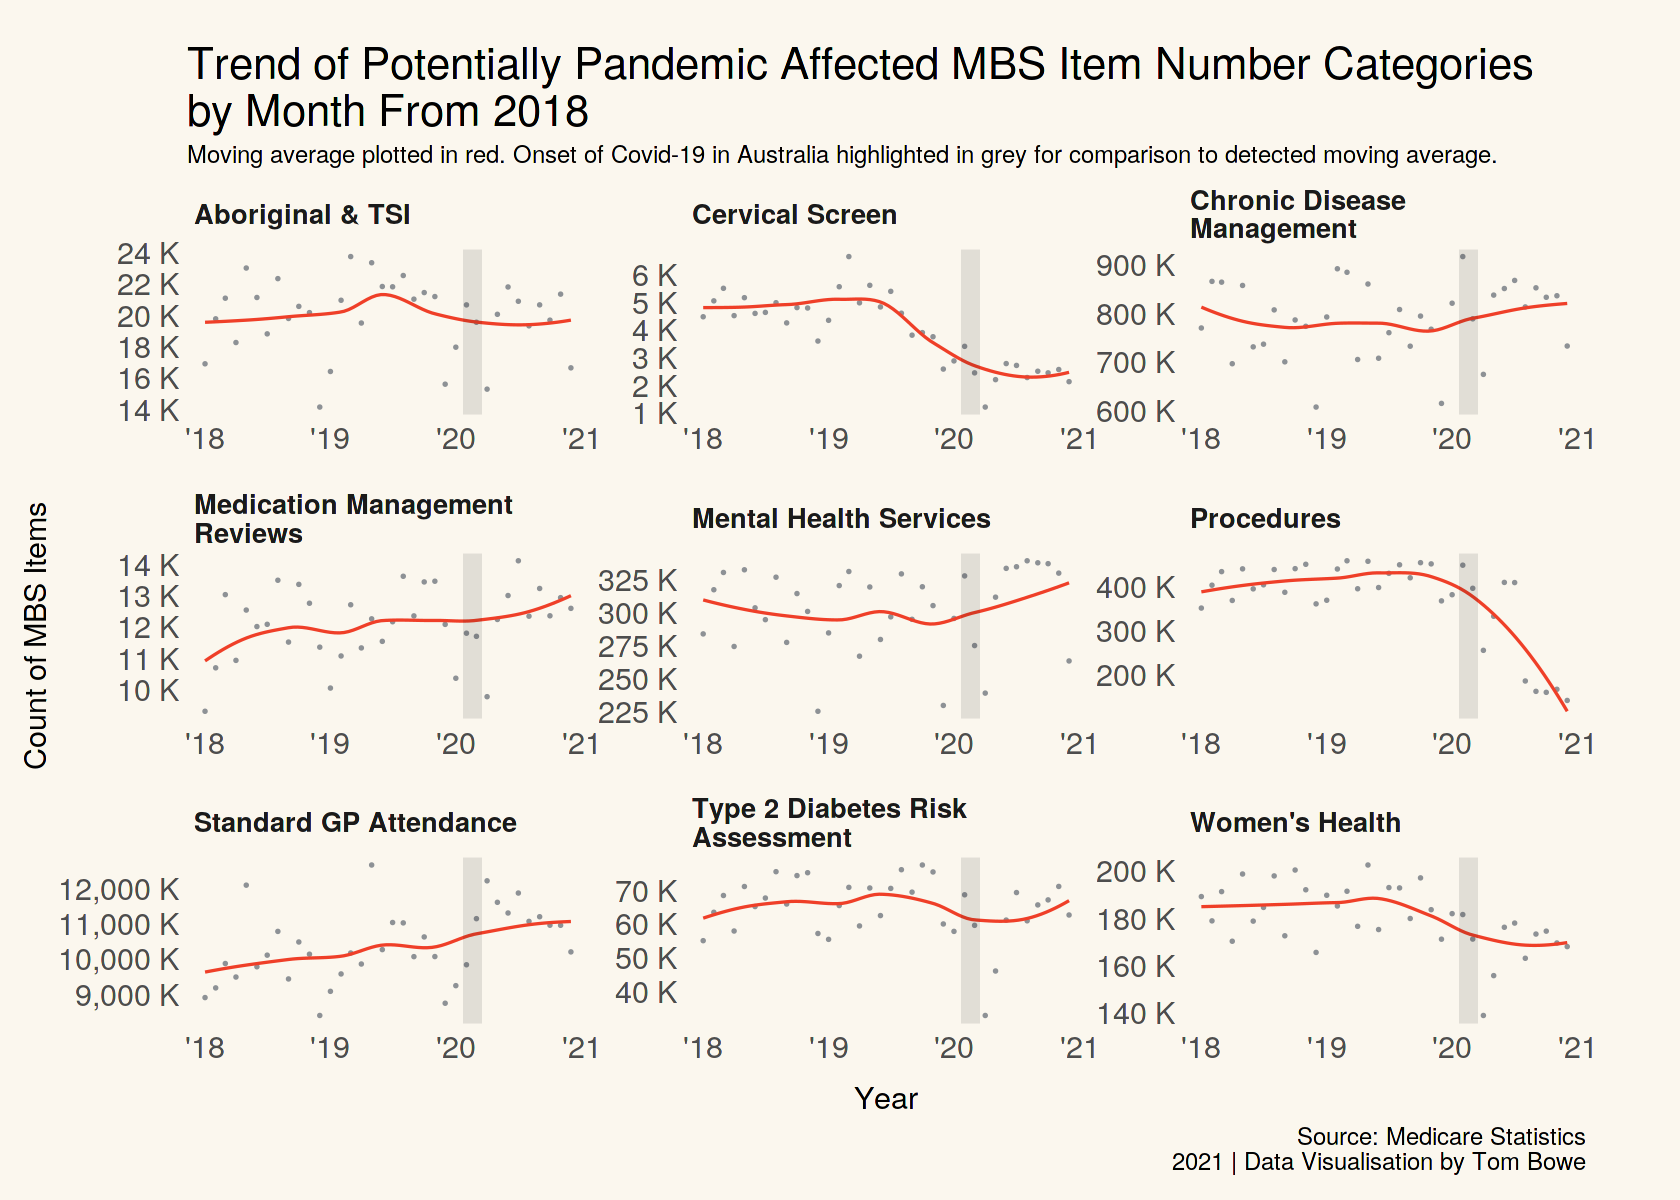

In [11]:
# Arrange the data
facet_trend_detail <-
    subset(facet_trend_inc, Date > cpt_date) %>%
    subset(Name %in% c("Aboriginal & TSI",
                       "Cervical Screen",
                       "Chronic Disease Management",
                       "Type 2 Diabetes Risk Assessment",
                       "Mental Health Services",
                       "Standard GP Attendance",
                       "Women's Health",
                       "Medication Management Reviews",
                       "Procedures"))

# Visualise:
fig_height(10)
ggplot(facet_trend_detail, aes(x = Date, y = x)) +
geom_point(size=.5, colour = col_pt) +
geom_smooth(se=FALSE, colour = col_ln, lwd = .7, span = .5, formula = y ~ x, method = loess) +
geom_vline(aes(xintercept = as.Date("2020-02-18")), size = 4, alpha = .1) +
scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-3, accuracy = 1, big.mark = ",")) +
scale_x_date(date_breaks = "1 year", date_labels = "'%y") +
theme_tb() +
theme_tb_blan() +
facet_wrap(~ Name, scales = "free", ncol = 3, labeller = label_wrap_gen()) +
labs(y = "Count of MBS Items", 
     x = "Year",
     title = "Trend of Potentially Pandemic Affected MBS Item Number Categories\nby Month From 2018",
     subtitle = "Moving average plotted in red. Onset of Covid-19 in Australia highlighted in grey for comparison to detected moving average.",
     caption = capt)

In [12]:
head(facet_trend_detail)

,Date,Name,x
,<date>,<chr>,<int>
91,2018-01-01,Aboriginal & TSI,16928
92,2018-02-01,Aboriginal & TSI,19798
93,2018-03-01,Aboriginal & TSI,21115
94,2018-04-01,Aboriginal & TSI,18286
95,2018-05-01,Aboriginal & TSI,23040
96,2018-06-01,Aboriginal & TSI,21160


In [13]:
datalist <- 
    list()

for (i in c(
  "Cervical Screen",
  "Aboriginal & TSI",
  "Chronic Disease Management",
  "Type 2 Diabetes Risk Assessment",
  "Mental Health Services",
  "Standard GP Attendance",
  "Procedures",
  "Medication Management Reviews",
  "Women's Health"
))
{
  dat <-
    subset(facet_trend_inc, Date > cpt_date) %>%
    subset(Name == i)
  mcpt_lp <-
    cpt.mean(dat$x, method = 'BinSeg', Q = cpt_num)
  mcpt_lp.pts <-
    attributes(mcpt_lp)$cpts
  mcpt_lp.mean <-
    attributes(mcpt_lp)$param.est$mean
  dat$mean <-
    rep(mcpt_lp.mean, c(mcpt_lp.pts[1], diff(mcpt_lp.pts)))
  dat$drop <-
    as.double((mcpt_lp.mean[2] - mcpt_lp.mean[1]) / mcpt_lp.mean[1])
  dat$i <-
    i
  datalist[[i]] <-
    dat
}

cpt_inc <-
  do.call(rbind, datalist) %>%
  mutate(pre_post = "Temporary MBS Telehealth Services Included")

datalist <- 
    list()

for (i in c(
  "Cervical Screen",
  "Aboriginal & TSI",
  "Chronic Disease Management",
  "Type 2 Diabetes Risk Assessment",
  "Mental Health Services",
  "Standard GP Attendance",
  "Procedures",
  "Medication Management Reviews",
  "Women's Health"
))
{
  dat <-
    subset(facet_trend_exc, Date > cpt_date) %>%
    subset(Name == i)
  mcpt_lp <-
    cpt.mean(dat$x, method = 'BinSeg', Q = cpt_num)
  mcpt_lp.pts <-
    attributes(mcpt_lp)$cpts
  mcpt_lp.mean <-
    attributes(mcpt_lp)$param.est$mean
  dat$mean <-
    rep(mcpt_lp.mean, c(mcpt_lp.pts[1], diff(mcpt_lp.pts)))
  dat$drop <-
    as.double((mcpt_lp.mean[2] - mcpt_lp.mean[1]) / mcpt_lp.mean[1])
  dat$i <-
    i
  datalist[[i]] <-
    dat
}

cpt_exc <-
  do.call(rbind, datalist) %>%
  mutate(pre_post = "Temporary MBS Telehealth Services Excluded")

cpt <- 
  rbind(cpt_exc, cpt_inc)

Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”
Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”
Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”
Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”
Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of ch

## Change Point Detection in Each Check-up Type

Below I've applied the binary segmentation changepoint detection method and asked it to detect a single point of change in average check-up frequency between 2018 and 2020. I have applied this method both for in person check-up data only to quantify the anticipated negative effect, and also for data including the temporary MBS telehealth service item numbers to quantify the change in actual GP interactions, both in person and over the phone.

### *Excluding* Temporary MBS Telehealth Services
I note that some items were affected as anticipated; however, others seemed to have had a head start on the pandemic while Procedures was somewhat delayed in its drop.

The lag in procedures seems unique. Common procedures from your GP according to the MBS includes Spirometry, ECG, Abscess/Haematoma Incision, Diagnostic Biopsy Skin, and Diagnostic Biopsy of Mucous Membrane. These visits may have been pre-booked in advance which could have caused this delay.

As for the inverse head start: 
>Some are only slight such as Aboriginal and Torres Strait Islander People's Health Assessments and Cervical Screening; but these head starts may have been a by-product of their small overall volume and an unfortunate effect of random variation on the accuracy of the change point detection method. 

The fact remains though, that a drop was observed. The higher sample size visit types such as standard GP attendance, women's health, and chronic disease management all had detected changepoints exactly as hypothesised, I.e. within the grey band representing the onset of Covid-19 in Australia.

Not every item was affected, we can see a spurious change point manifest in Medication Management Reviews which indicates the function struggled to find a change point.

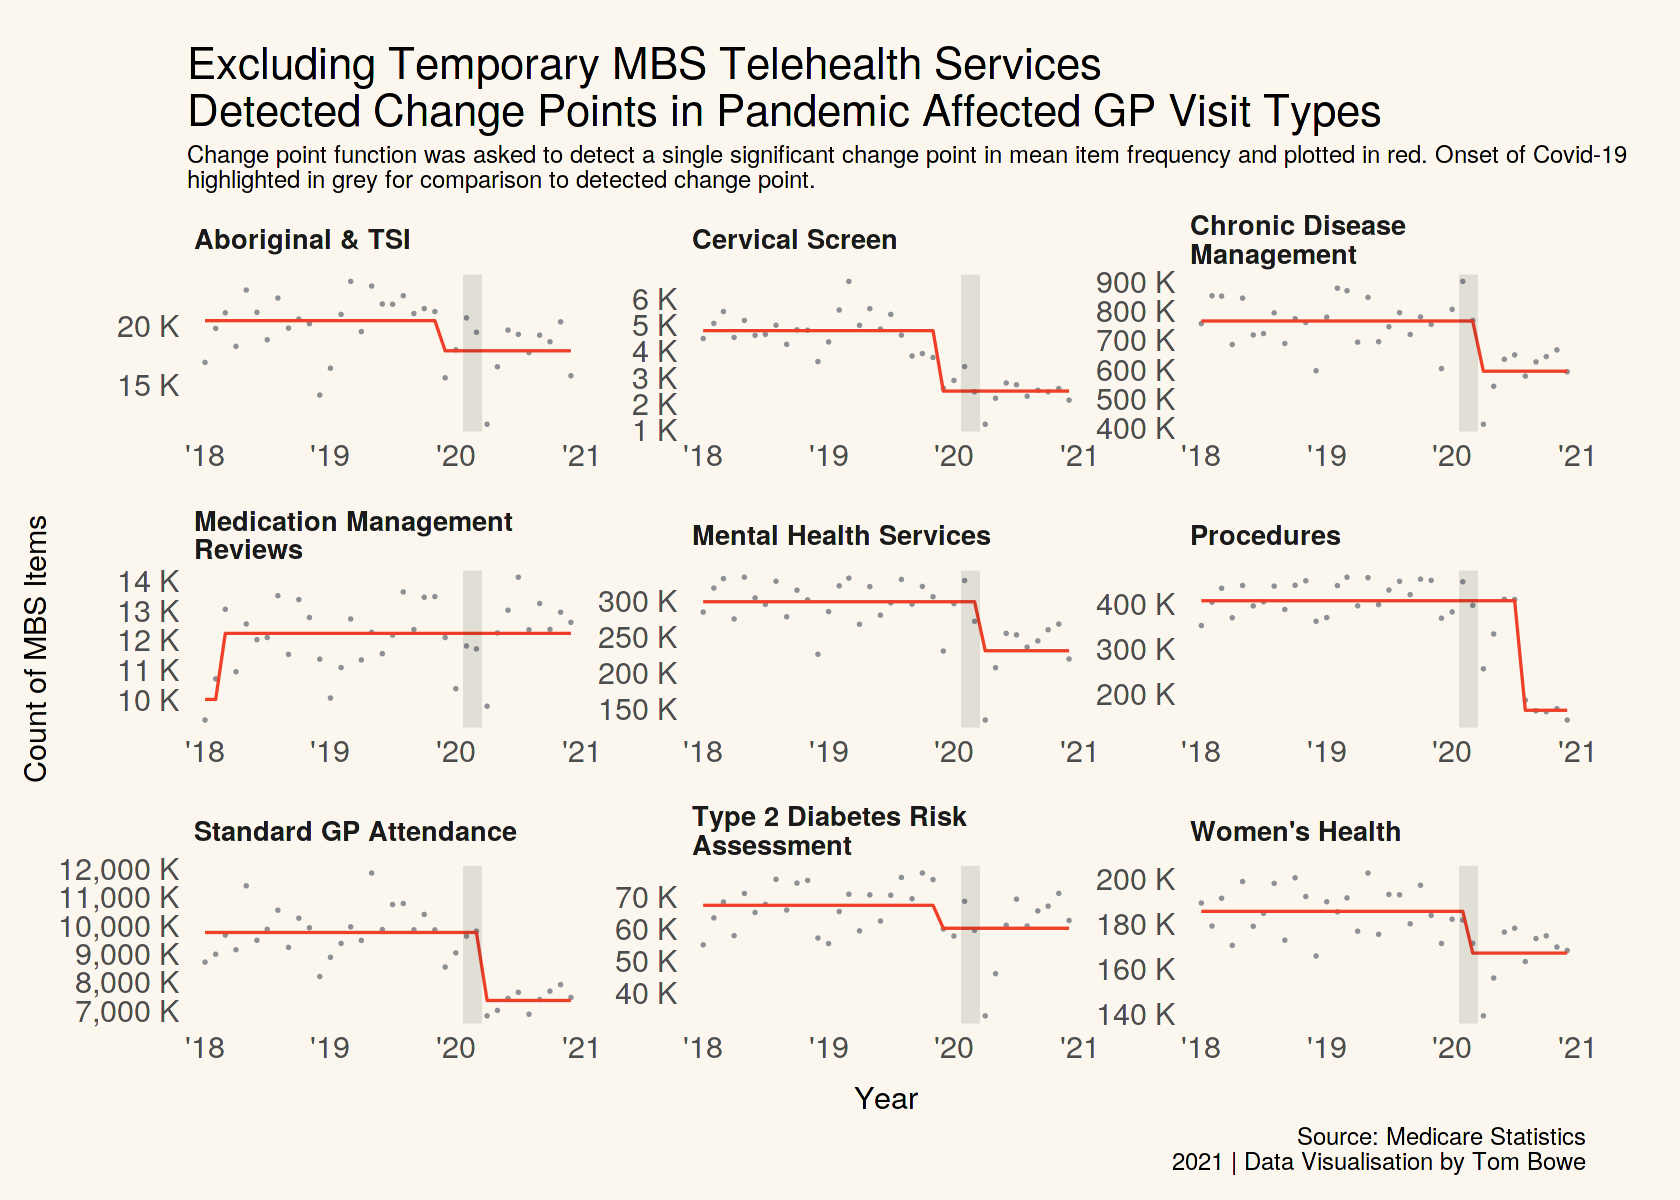

In [14]:
# Visualise:
fig_height(10)
ggplot(cpt_exc, aes(x = Date, y = x)) +
geom_point(size=.5, colour = col_pt) +
geom_line(aes(Date, mean),colour = col_ln, lwd = .7) +
geom_vline(aes(xintercept = as.Date("2020-02-18")), size = 4, alpha = .1) +
scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-3, accuracy = 1, big.mark = ",")) +
scale_x_date(date_breaks = "1 year", date_labels = "'%y") +
theme_tb() +
theme_tb_blan() +
facet_wrap(~ Name, scales = "free", ncol = 3, labeller = label_wrap_gen()) +
labs(y = "Count of MBS Items", 
     x = "Year",
     title = "Excluding Temporary MBS Telehealth Services\nDetected Change Points in Pandemic Affected GP Visit Types",
     subtitle = "Change point function was asked to detect a single significant change point in mean item frequency and plotted in red. Onset of Covid-19
highlighted in grey for comparison to detected change point.",
     caption = capt)

### *Including* Temporary MBS Telehealth Services
Here we note a more valid reflection of actual interactions by Australians with their GPs. These additional telehealth items include both videoconferencing technology, or just standard voice interactions over the phone.

Some check-up categories did not have a equivalent telehealth items and these should be noted. The categories which did not have telehealth equivalents include:
* Cervical Screen
* Procedures
* Type 2 Diabetes Risk Management
* Women's Health
These are mostly for obvious reasons E.g. biopsies (Procedures), and insertion of an Intra Uterine Device (IUD) (Women's Health).

The biggest insight we see here is that: 
><span style="color:#EF3F28;"> **Aboriginal and Torres Strait Islander Health Assessments have been negatively impacted by 6% despite the presence of a temporary MBS telehealth item (12% excluding telehealth)**. </span>

This is the only GP interaction which displayed this behaviour. In all other cases, GP interactions increased. This could be a side effect of the remoteness of some aboriginal communities, lack of phone signal, and a lack of access to teleconference technologies. Either way, this is an important area for improvement.


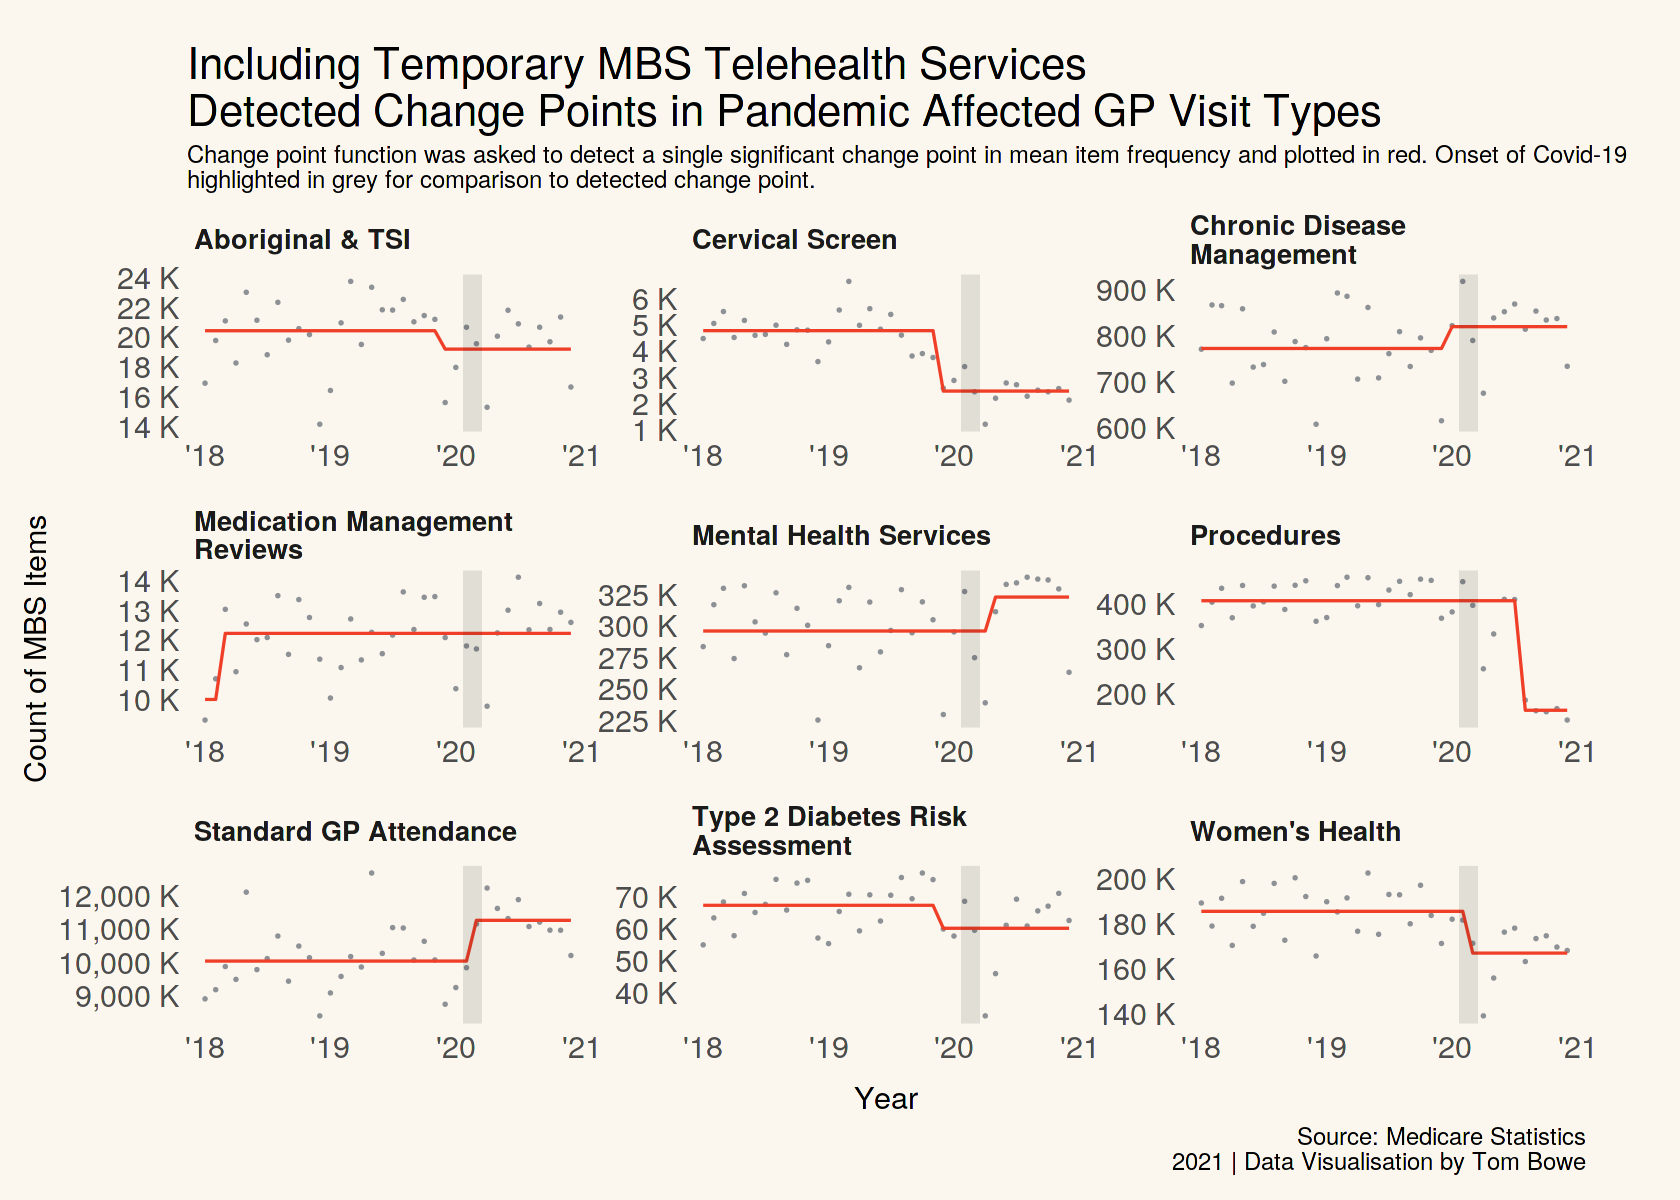

In [15]:
# Visualise:
fig_height(10)
ggplot(cpt_inc, aes(x = Date, y = x)) +
geom_point(size=.5, colour = col_pt) +
geom_line(aes(Date, mean),colour = col_ln, lwd = .7) +
geom_vline(aes(xintercept = as.Date("2020-02-18")), size = 4, alpha = .1) +
scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-3, accuracy = 1, big.mark = ",")) +
scale_x_date(date_breaks = "1 year", date_labels = "'%y") +
theme_tb() +
theme_tb_blan() +
facet_wrap(~ Name, scales = "free", ncol = 3, labeller = label_wrap_gen()) +
labs(y = "Count of MBS Items", 
     x = "Year",
     title = "Including Temporary MBS Telehealth Services\nDetected Change Points in Pandemic Affected GP Visit Types",
     subtitle = "Change point function was asked to detect a single significant change point in mean item frequency and plotted in red. Onset of Covid-19
highlighted in grey for comparison to detected change point.",
     caption = capt)

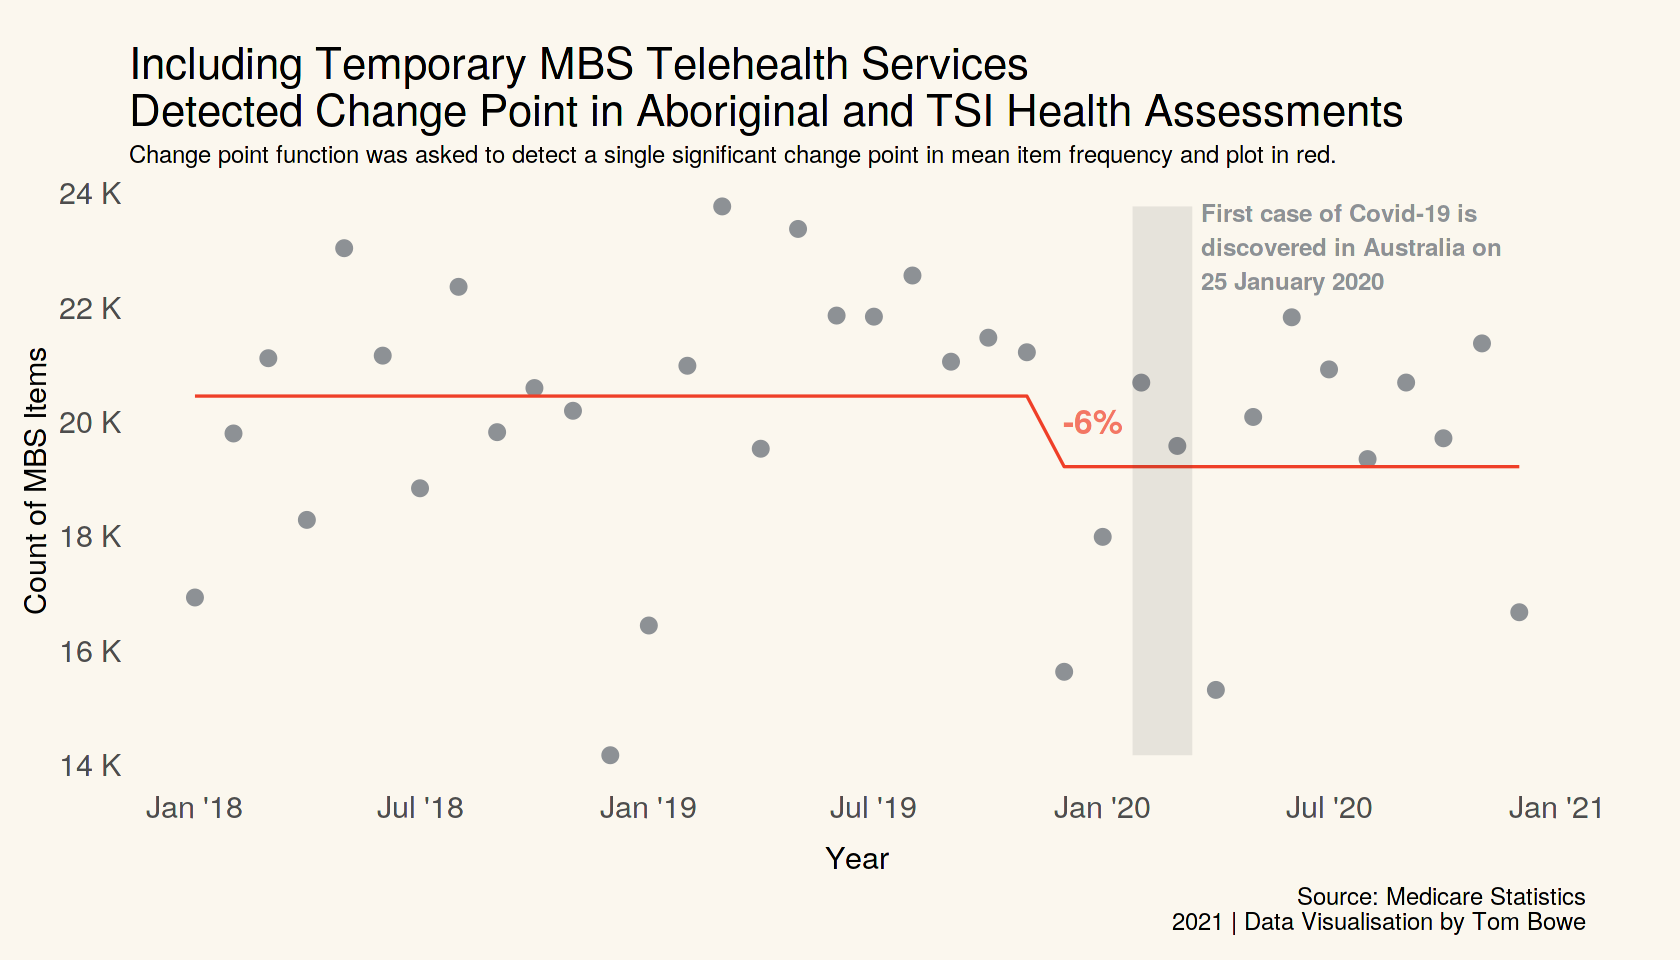

In [16]:
# Arrange the data
cpt_ati <-
subset(cpt_inc, i == 'Aboriginal & TSI')

# Define the min and max points on the y axis
minp <- min(cpt_ati$x)
maxp <- max(cpt_ati$x)

# Create the data frame to draw a polygon visualising the begging of the covid pandemic in Australia
pandemic_start <- data.frame(x=c(cov_start1,cov_start2,cov_start2,cov_start1), 
                             y=c(minp,minp,maxp,maxp))

# Visualise
fig_height(8)
ggplot(cpt_ati, aes(x = Date, y = x)) +
geom_point(size=4, colour = col_pt) +
geom_line(aes(Date, mean),colour = col_ln, lwd = .7) +
geom_polygon(data=pandemic_start, x=pandemic_start$x, y=pandemic_start$y, alpha = .1) +
annotate("text", x = as.Date("2019-11-30"), adj = 0, size = 7, fontface="bold", colour = col_ln, y = 20000, alpha = .7, label = '-6%') +
annotate("text", x = as.Date("2020-03-20"), adj = 0, size = 5, fontface="bold", colour = col_pt, y = maxp*.97, label = "First case of Covid-19 is\ndiscovered in Australia on\n25 January 2020") +
scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-3, accuracy = 1, big.mark = ",")) +
scale_x_date(breaks = breaks_pretty(n = 8), date_labels = "%b '%y") +
theme_tb() +
theme_tb_blan() +
labs(y = "Count of MBS Items", 
     x = "Year",
     title = "Including Temporary MBS Telehealth Services\nDetected Change Point in Aboriginal and TSI Health Assessments",
     subtitle = "Change point function was asked to detect a single significant change point in mean item frequency and plot in red.",
     caption = capt)

I also plot the ranked percentage drop for each category of GP visit. I note that Asthma Cycle of Care is most heavily affected, followed closely by procedures then Cervical Screen.

This is a worrying insight that regular cervical screens have been so negatively affected by the pandemic which could have ongoing health impacts on Australian Women. It should be noted that on 1 May 2017, the frequency of Cervical Screens recommended to women dropped. This will be investigated next to ensure that it is not interfering with our analysis.

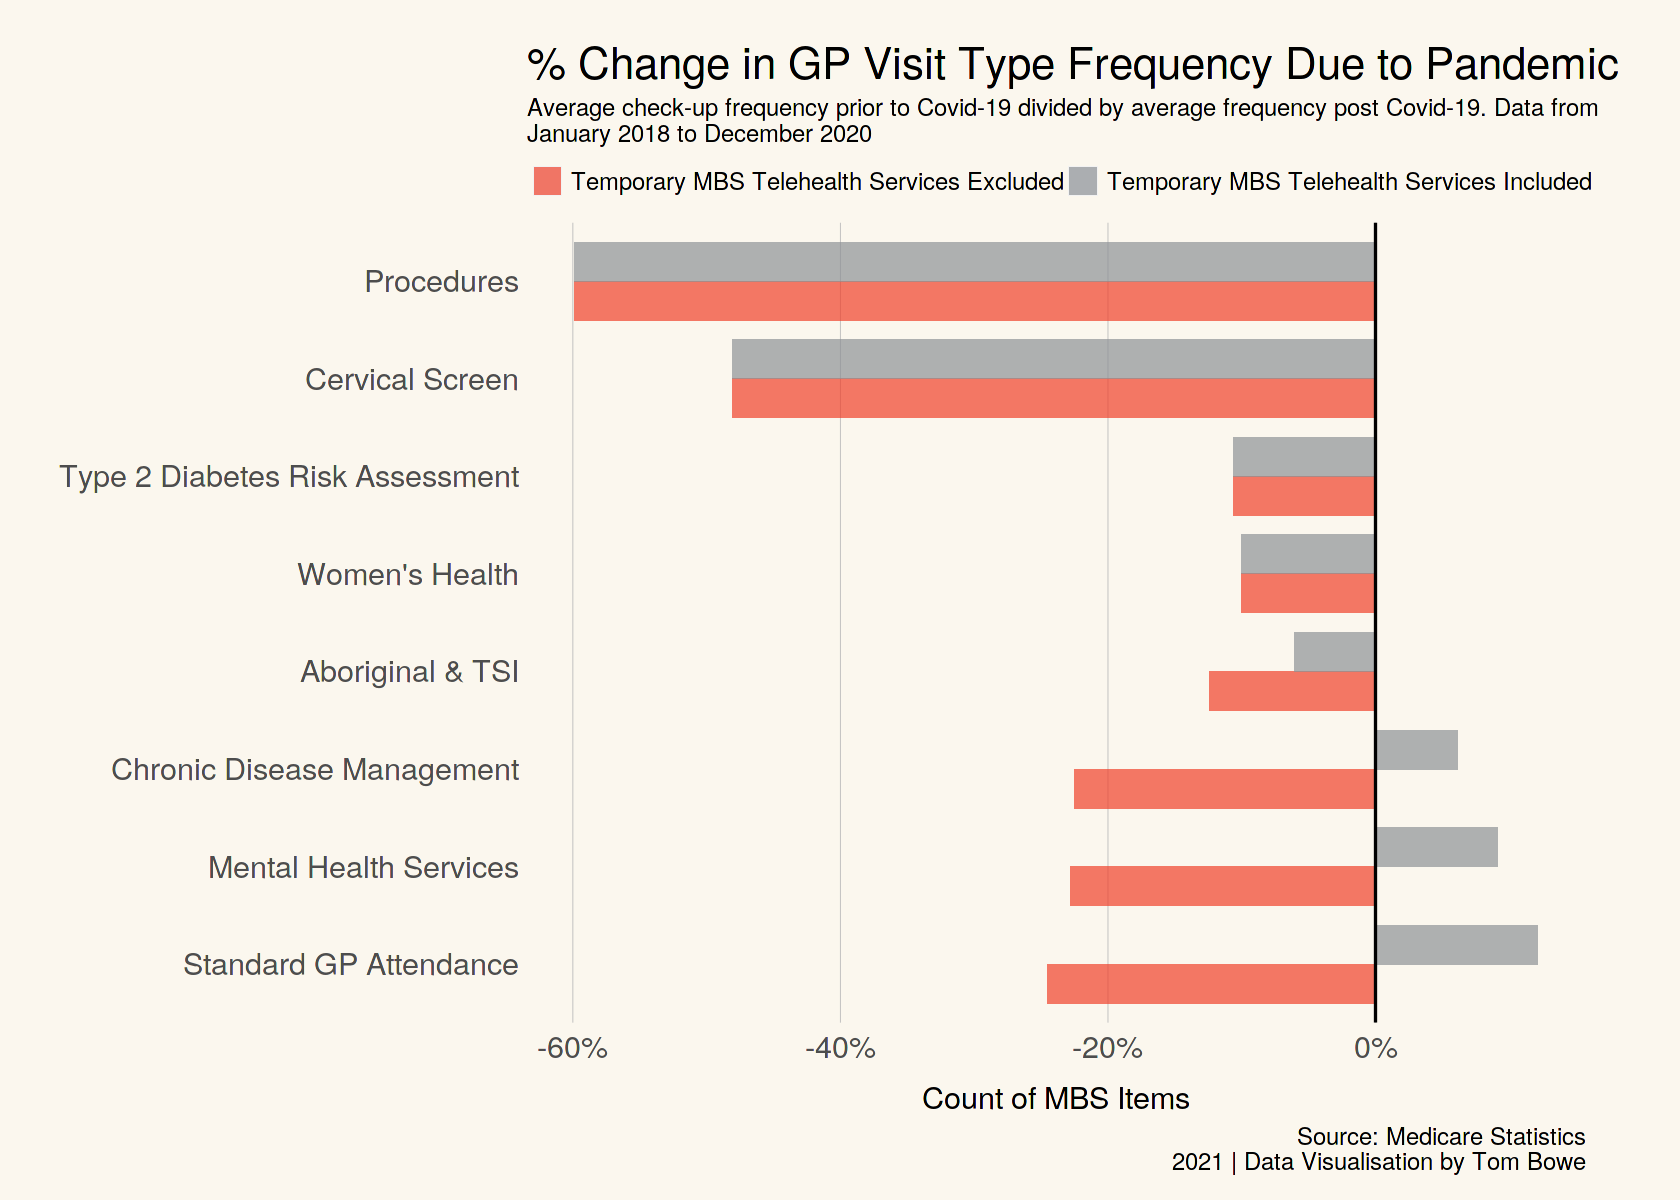

In [17]:
# Arrange the data
cpt_subset <-
    subset(cpt, Name != "Medication Management Reviews")
cpt_drops <-
    aggregate(cpt_subset$drop, by=list(Name=cpt_subset$Name, pre_post=cpt_subset$pre_post), FUN=mean)

# Visualise:
fig_height(10)
ggplot(cpt_drops, aes(x = reorder(Name, -x), y = x, fill = pre_post)) +
geom_bar(stat = "identity",
         position = "dodge",
         alpha = .7,
         width = .8) +
geom_hline(yintercept = 0, size = .7) +
scale_fill_manual(values = c(col_ln, col_pt), name = "Dialogue Type") +
theme_tb() +
theme_tb_vert() +
theme(legend.title = element_blank(),
    legend.position = "top",
    legend.background = element_blank(),
    legend.text = element_text(size = 14)) +
scale_y_continuous(labels = percent_format()) +
coord_flip() +
labs(y = "Count of MBS Items", 
     x = "",
     title = "% Change in GP Visit Type Frequency Due to Pandemic",
     subtitle = "Average check-up frequency prior to Covid-19 divided by average frequency post Covid-19. Data from\nJanuary 2018 to December 2020",
       caption = capt)

## Change Point Detection in Each Australian State and Territory

Now I take a look at change points for each state and terrritory for checkups overall.

### *Excluding* Temporary MBS Telehealth Services
Every state and territory displayed the predicted pattern of a significant drop in mean frequency on the onset of Covid-19 in Australia. There were no exceptions here and the change points were all identical being April 2020.

In [18]:
# Arrange the data
facet_trend_state_inc <-
    aggregate(mbs$Count, by=list(Date=mbs$Date, State=mbs$State), FUN=sum)

facet_trend_state_exc <-
    aggregate(mbs_precovid$Count, by=list(Date=mbs_precovid$Date, State=mbs_precovid$State), FUN=sum)

# Loop through and detect changes
datalist <- 
    list()

for (i in c(
  "NSW",
  "ACT",
  "VIC",
  "TAS",
  "SA",
  "WA",
  "NT",
  "QLD"
))
{
  dat <-
    subset(facet_trend_state_inc, Date > cpt_date) %>%
    subset(State == i)
  mcpt_lp <-
    cpt.mean(dat$x, method = 'BinSeg', Q = cpt_num)
  mcpt_lp.pts <-
    attributes(mcpt_lp)$cpts
  mcpt_lp.mean <-
    attributes(mcpt_lp)$param.est$mean
  dat$mean <-
    rep(mcpt_lp.mean, c(mcpt_lp.pts[1], diff(mcpt_lp.pts)))
  dat$drop <-
    as.double((mcpt_lp.mean[2] - mcpt_lp.mean[1]) / mcpt_lp.mean[1])
  dat$i <-
    i
  datalist[[i]] <-
    dat
}

cpt_state_inc <-
  do.call(rbind, datalist) %>%
  mutate(pre_post = "Temporary MBS Telehealth Services Included")

for (i in c(
  "NSW",
  "ACT",
  "VIC",
  "TAS",
  "SA",
  "WA",
  "NT",
  "QLD"
))
{
  dat <-
    subset(facet_trend_state_exc, Date > cpt_date) %>%
    subset(State == i)
  mcpt_lp <-
    cpt.mean(dat$x, method = 'BinSeg', Q = cpt_num)
  mcpt_lp.pts <-
    attributes(mcpt_lp)$cpts
  mcpt_lp.mean <-
    attributes(mcpt_lp)$param.est$mean
  dat$mean <-
    rep(mcpt_lp.mean, c(mcpt_lp.pts[1], diff(mcpt_lp.pts)))
  dat$drop <-
    as.double((mcpt_lp.mean[2] - mcpt_lp.mean[1]) / mcpt_lp.mean[1])
  dat$i <-
    i
  datalist[[i]] <-
    dat
}

cpt_state_exc <-
  do.call(rbind, datalist) %>%
  mutate(pre_post = "Temporary MBS Telehealth Services Excluded")

Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”
Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”
Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”
Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”
Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of ch

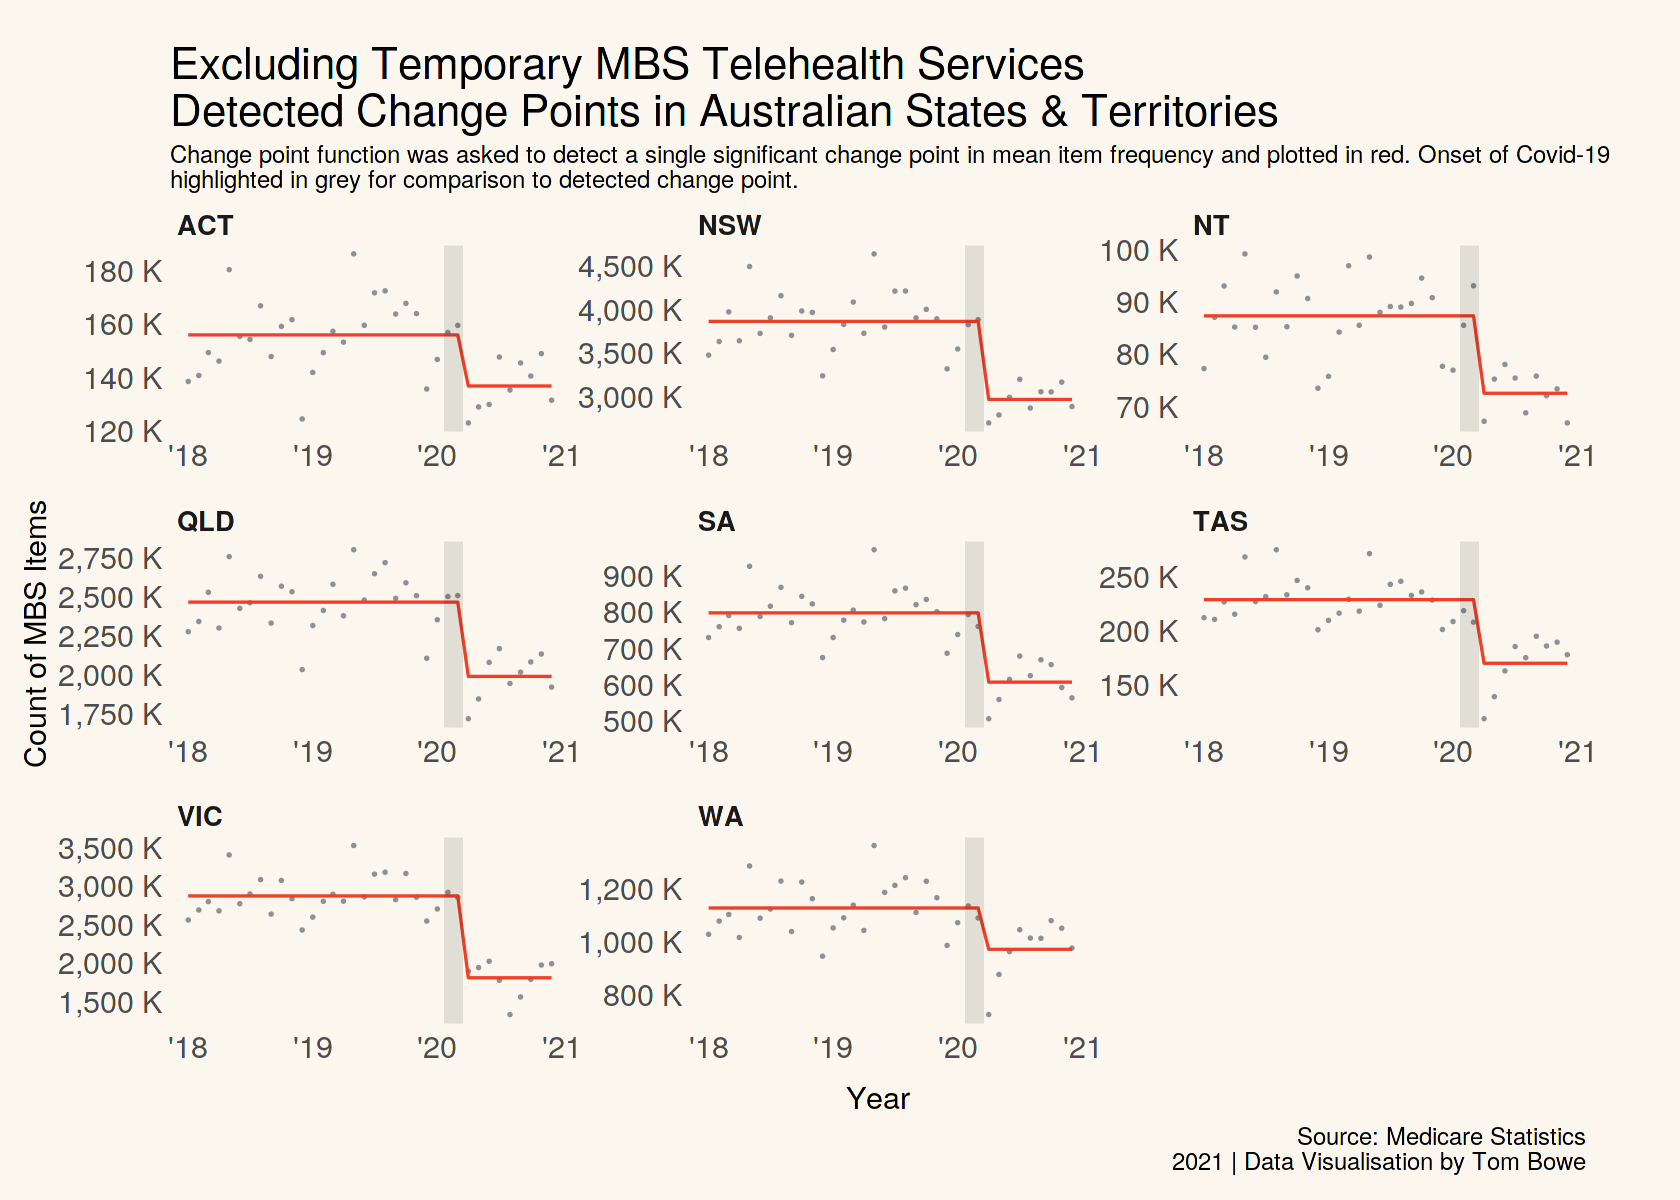

In [19]:
# Visualise:
fig_height(10)
ggplot(cpt_state_exc, aes(x = Date, y = x)) +
geom_point(size=.5, colour = col_pt) +
geom_line(aes(Date, mean),colour = col_ln, lwd = .7) +
geom_vline(aes(xintercept = as.Date("2020-02-18")), size = 4, alpha = .1) +
scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-3, accuracy = 1, big.mark = ",")) +
scale_x_date(date_breaks = "1 year", date_labels = "'%y") +
theme_tb() +
theme_tb_blan() +
facet_wrap(~ State, scales = "free", ncol = 3, labeller = label_wrap_gen()) +
labs(y = "Count of MBS Items", 
     x = "Year",
     title = "Excluding Temporary MBS Telehealth Services\nDetected Change Points in Australian States & Territories",
     subtitle = "Change point function was asked to detect a single significant change point in mean item frequency and plotted in red. Onset of Covid-19
highlighted in grey for comparison to detected change point.",
     caption = capt)

### *Including* Temporary MBS Telehealth Services
Western Australia is the only state in which the change point function couldn't reliably detect a change near the onset of Covid-19. The Northern Territory exibits a delayed effect.

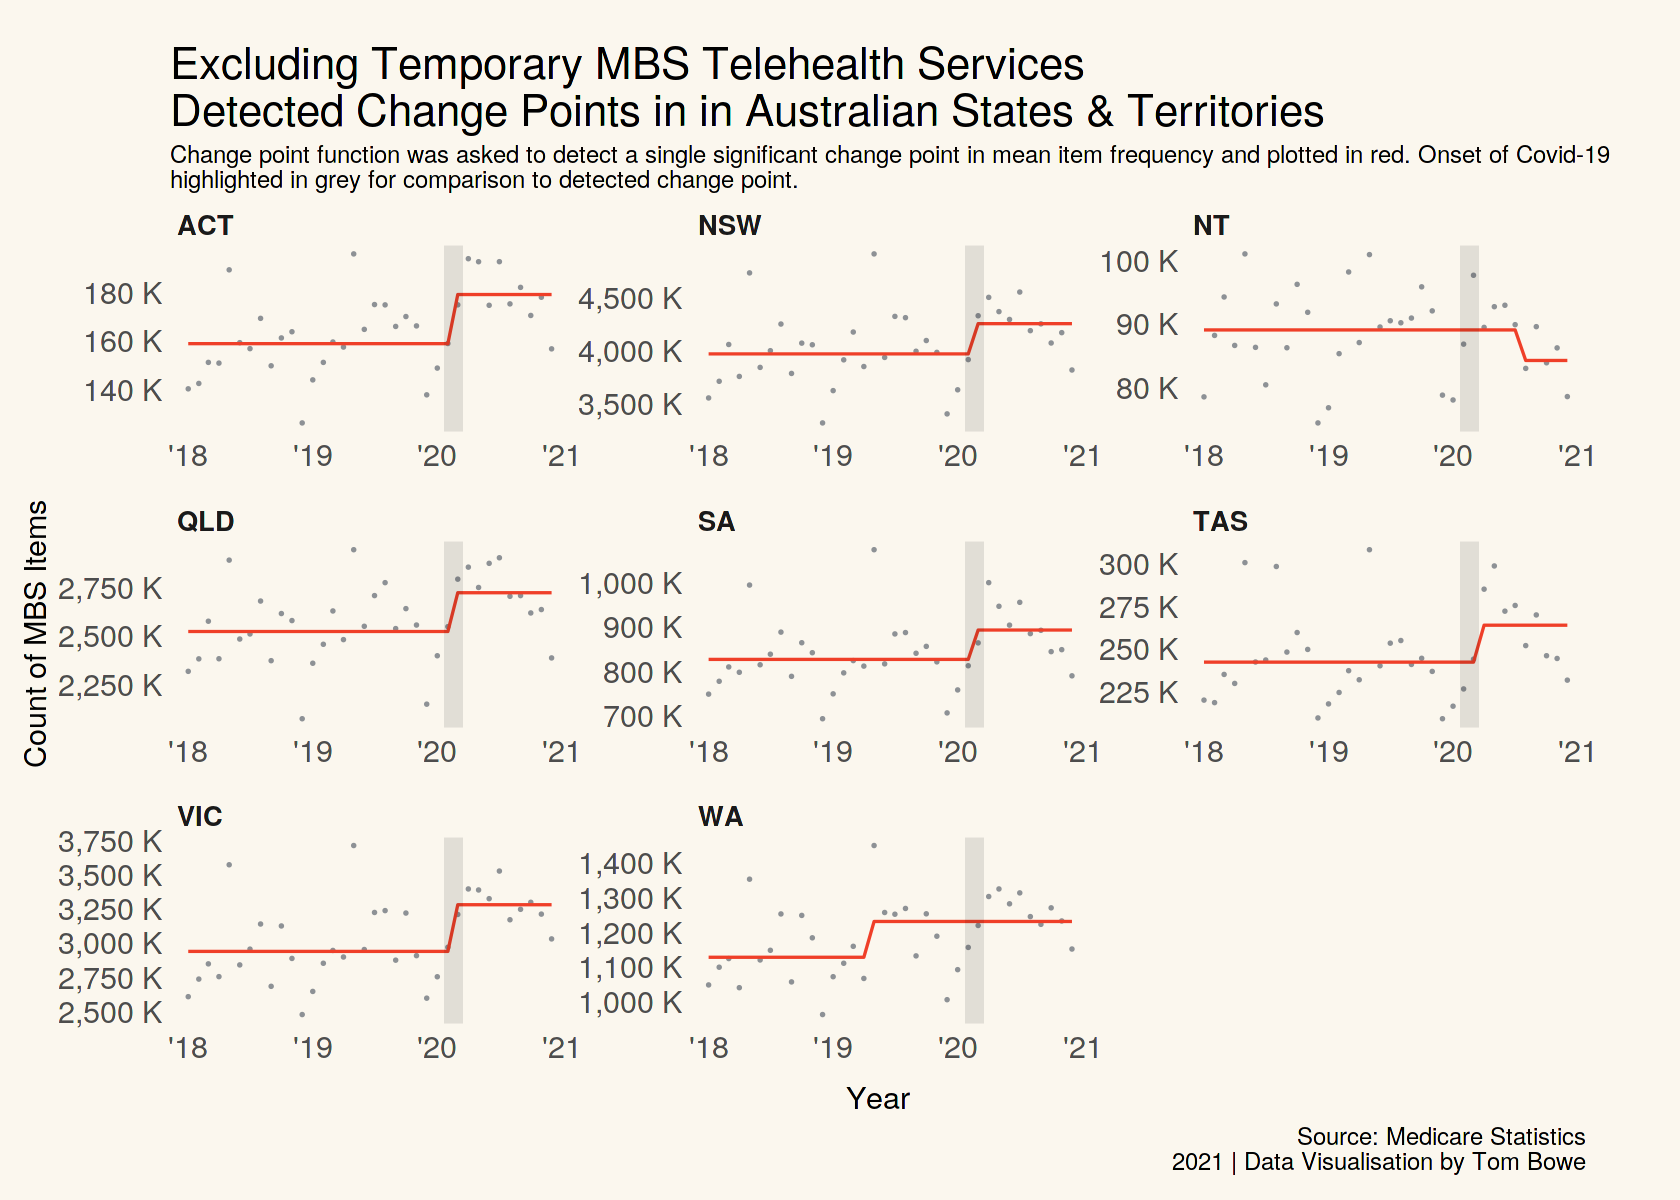

In [20]:
# Visualise:
fig_height(10)
ggplot(cpt_state_inc, aes(x = Date, y = x)) +
geom_point(size=.5, colour = col_pt) +
geom_line(aes(Date, mean),colour = col_ln, lwd = .7) +
geom_vline(aes(xintercept = as.Date("2020-02-18")), size = 4, alpha = .1) +
scale_y_continuous(labels = unit_format(unit = "K", scale = 1e-3, accuracy = 1, big.mark = ",")) +
scale_x_date(date_breaks = "1 year", date_labels = "'%y") +
theme_tb() +
theme_tb_blan() +
facet_wrap(~ State, scales = "free", ncol = 3, labeller = label_wrap_gen()) +
labs(y = "Count of MBS Items", 
     x = "Year",
     title = "Excluding Temporary MBS Telehealth Services\nDetected Change Points in in Australian States & Territories",
     subtitle = "Change point function was asked to detect a single significant change point in mean item frequency and plotted in red. Onset of Covid-19
highlighted in grey for comparison to detected change point.",
     caption = capt)

## Determining the Change in Average Cervical Screen Frequency Following on From Changes in Official Recommendations and into the Covid-19 Pandemic.

It is a known fact that the frequency of Cervical Screening dropped following on from changes made on 1 May 2017. Has this meddled with any insights we gained from our previous change point detection?

I have extended the date range on the change point detection and I have asked it to detect 2 changes rather than a single point as before. The result is indeed a clear 28% drop following on from the 1 May 2017 change, followed by a period of stability, then a much larger drop of 47% at the onset of Covid-19. We note a lag in the effect of the 1 May changes and a head start on the Covid-19 drop compared to the actual start of the pandemic. This lag effect would be expected following on from regulatory changes (the change would not be immediate), and I note the influence of the smaller volume on random variation in cervical screen trends and therefore the detected change points could be slightly affected by this. 

The fact remains that drops were detected, and the drop as a result of the pandemic was far greater than the initial drop from 1 May 2017.

In [23]:
# Detect changepoints in cervical screen items over a longer period
cpt_cs_long <-
    subset(facet_trend_inc, Date > as.Date("2014-01-01")) %>%
    subset(Name == "Cervical Screen")
mcpt_cs <- cpt.mean(cpt_cs_long$x, method='BinSeg', Q=2)
mcpt_cs.pts <- attributes(mcpt_cs)$cpts
mcpt_cs.mean <- attributes(mcpt_cs)$param.est$mean
cpt_cs_long$mean <- rep(mcpt_cs.mean,c(mcpt_cs.pts[1],diff(mcpt_cs.pts)))
cpt_drop_1 <- paste(as.integer((mcpt_cs.mean[2]-mcpt_cs.mean[1])/mcpt_cs.mean[1]*100),"%")
cpt_drop_2 <- paste(as.integer((mcpt_cs.mean[3]-mcpt_cs.mean[2])/mcpt_cs.mean[2]*100),"%")

Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”


In [24]:
# Preview data
head(cpt_cs_long)

,Date,Name,x,mean
,<date>,<chr>,<int>,<dbl>
296,2014-02-01,Cervical Screen,7357,6648.152
297,2014-03-01,Cervical Screen,7811,6648.152
298,2014-04-01,Cervical Screen,6512,6648.152
299,2014-05-01,Cervical Screen,7882,6648.152
300,2014-06-01,Cervical Screen,6966,6648.152
301,2014-07-01,Cervical Screen,7118,6648.152


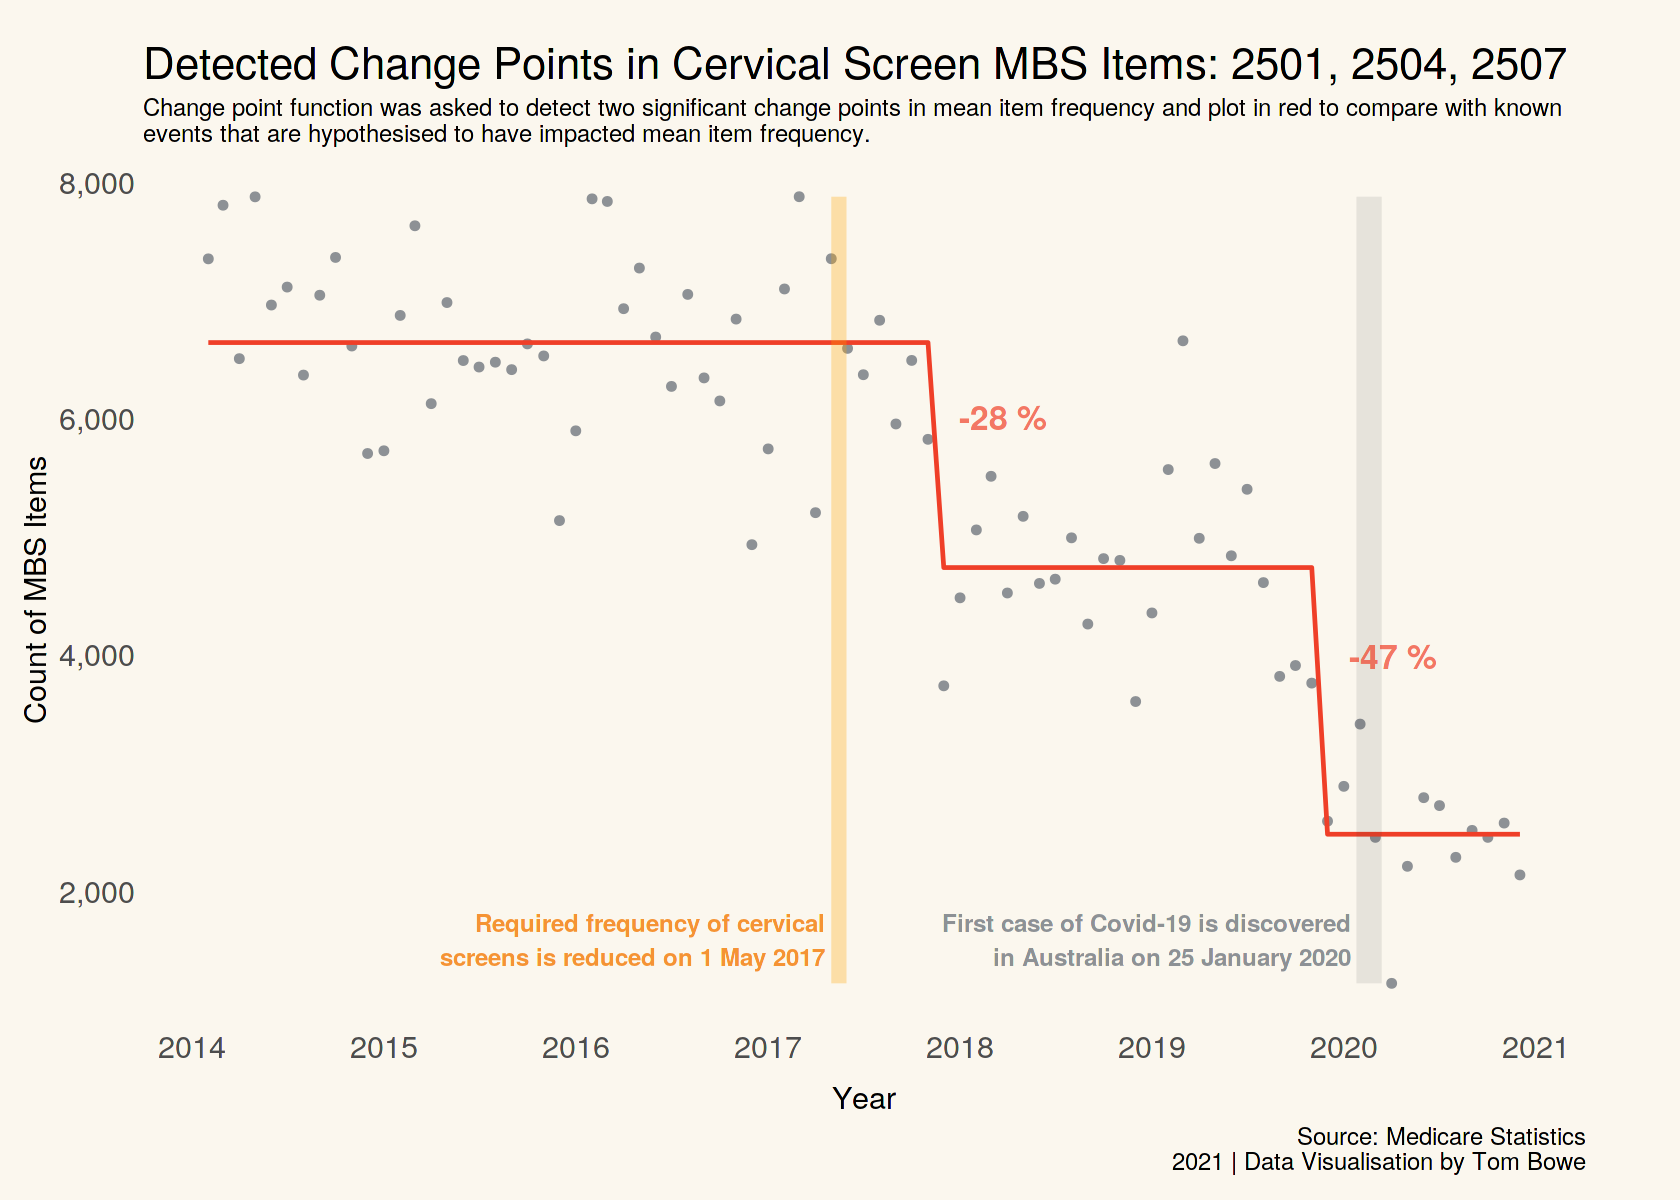

In [25]:
# Define the min and max points on the y axis
minp <- min(cpt_cs_long$x)
maxp <- max(cpt_cs_long$x)

# Create the data frame to draw a polygon visualising the begging of the covid pandemic in Australia
pandemic_start <- data.frame(x=c(cov_start1,cov_start2,cov_start2,cov_start1), 
                             y=c(minp,minp,maxp,maxp))

# Create the data frame to draw a polygon visualising the beginning of the cervical screening changes
cerv_start <- data.frame(x=c(as.Date("2017-05-01"),as.Date("2017-05-30"),as.Date("2017-05-30"),as.Date("2017-05-01")), 
                             y=c(minp,minp,maxp,maxp))

# Visualise
fig_height(10)
ggplot(cpt_cs_long) +
geom_point(aes(x=Date,y=x), size=2, colour = col_pt) +
geom_line(aes(x=Date,y=mean),colour = col_ln, lwd = 1) +
geom_polygon(data=cerv_start, x=cerv_start$x, y=cerv_start$y, fill = "orange", alpha = .3) +
geom_polygon(data=pandemic_start, x=pandemic_start$x, y=pandemic_start$y, alpha = .1) +
annotate("text", x = as.Date("2017-04-20"), adj = 1, size = 5, y = minp*1.3, colour = "#F59334", fontface = "bold", label = "Required frequency of cervical\nscreens is reduced on 1 May 2017") +
annotate("text", x = as.Date("2020-01-15"), adj = 1, size = 5, y = minp*1.3, colour = col_pt, fontface = "bold", label = "First case of Covid-19 is discovered\nin Australia on 25 January 2020") +
annotate("text", x = as.Date("2017-12-30"), adj = 0, size = 7, fontface="bold", colour = col_ln, y = ((mcpt_cs.mean[1]-mcpt_cs.mean[2])/1.5)+mcpt_cs.mean[2], alpha = .7, label = cpt_drop_1) +
annotate("text", x = as.Date("2020-01-10"), adj = 0, size = 7, fontface="bold", colour = col_ln, y = ((mcpt_cs.mean[2]-mcpt_cs.mean[3])/1.5)+mcpt_cs.mean[3], alpha = .7, label = cpt_drop_2) +
scale_y_continuous(labels = comma) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
theme_tb() +
theme_tb_blan() +
labs(y = "Count of MBS Items", 
     x = "Year",
     title = "Detected Change Points in Cervical Screen MBS Items: 2501, 2504, 2507",
     subtitle = "Change point function was asked to detect two significant change points in mean item frequency and plot in red to compare with known\nevents that are hypothesised to have impacted mean item frequency.",
     caption = capt)